# Optical Navigation

## Decoupling Position Determination from Attitude Determination in Cislunar Space

###### V. Hunter Adams

This is a method of navigation for a spacecraft with onboard cameras capable of gathering information about the locations and the apparent sizes of the Earth, Sun, and Moon (like the CisLunar Explorers). However, the problem is best introduced with a thought experiment

###### Thought Experiment

You can imagine yourself floating, with your eyes closed, somewhere in the general neighborhood of the Earth, Sun, and Moon. You have no idea which way you're facing, and no idea where you are.

You open your eyes, and move your head around to observe your surroundings. You're wearing sunglasses, so the only things that you can see are the disks of the Earth, the Sun, and the Moon. You can't see any of the features on any of those celestial bodies (you can't tell, for instance, if you're looking at North America or Indonesia). All you see are three disks of light.

In this situation, the only information that you have is the following:

1. You know the sizes of each of the disks
2. You know the angular separation between each disk (a number between 0 and $\pi$)

Since, in the range [0,$\pi$], there is a one-to-one mapping with the cosine, you could represent that piece of information as cosine of the angle without losing any information.

You also have your cell phone, and you can use it to check the time and to call Earth. You call NASA, and they tell you the locations of the Earth, Moon, and Sun from their own frame of reference at the time that you specify. They can't tell you anything about the locations in your frame of reference, because they have no idea which way you're oriented. You can use that information, however, to figure out the legs of the triangle in space formed by the Earth, the Sun, and the Moon.

Given the known geometry of the triangle, and your own measurements of the sizes of the disks and their relative separations, you can figure out one of two possible locations in space that you could be. These are the only locations in space that will agree with your measurements.

The question is, if NASA flew someone out to meet you and that person told you your orientation relative to the Earth, how would that change your own knowledge of your location?

The situation would only change in that you and someone at NASA could agree upon a direction to face. You could both agree to turn such that your outstretched arms are parallel to the line connecting the Earth and the Moon, and your eyes are facing in the direction that keeps the Sun in front of you (assuming a nonsingular configuration).

Before changing your orientation, you knew you were at one of two locations. Now that you have aligned yourself in this way, you have the additional information of whether you must tilt your chin down or up to look at the Sun. If your head tilts down, then you know that you are at the position that is above the plane formed by the Earth, Sun, and Moon. If your head tilts up, then you are below. You haven't gained any accuracy, however, about either of those positions. You've only chosen one over the other. No additional information, other than the direction that your head tilts, has entered the situation.

If you are lost in space, you must solve the attitude problem to isolate your location. However, with extremely limited information about your position or dynamics, you can preferentially choose one possible location over the other.

Incidentally, if we had one additional celestial body, size and angular separation measurements would be sufficient to isolate one's position to a single location (assuming non-singular configuration of celestial bodies).

### System Dynamics Model

Import necessary libraries and planetary position data. Ephemerides and spacecraft trajectory from AGI's STK.

In [3]:
from IPython.display import Latex
import matplotlib.pyplot as plt
%matplotlib inline
import numpy
from numpy.linalg import inv
from numpy.linalg import pinv
import numpy.linalg
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D
import random
import Rots
from copy import deepcopy
import string

tStep=1800.
sigmaAcc = 5e-5

moonx, moony, moonz = numpy.loadtxt('Moon.csv', unpack=True)
sunx, suny, sunz = numpy.loadtxt('Sun.csv', unpack=True)
totaltime = numpy.arange(0, 1800*len(moonx), 1800.)
moonxspline = InterpolatedUnivariateSpline(totaltime, moonx)
moonyspline = InterpolatedUnivariateSpline(totaltime, moony)
moonzspline = InterpolatedUnivariateSpline(totaltime, moonz)
sunxspline = InterpolatedUnivariateSpline(totaltime, sunx)
sunyspline = InterpolatedUnivariateSpline(totaltime, suny)
sunzspline = InterpolatedUnivariateSpline(totaltime, sunz)

satx, saty, satz, satvx, satvy, satvz = numpy.loadtxt('Sat.csv', unpack=True)
traj = formTrajectory()
satx, saty, satz = traj[0], traj[1], traj[2]
truesatx, truesaty, truesatz = deepcopy(satx), deepcopy(saty), deepcopy(satz)
noiseaddx, noiseaddy, noiseaddz = [0], [0], [0]
for i in range(1,len(truesatx)):
    noiseaddx.extend([((tStep**2.)/2.)*numpy.random.normal(0, sigmaAcc) +
                      noiseaddx[i-1]])
    noiseaddy.extend([((tStep**2.)/2.)*numpy.random.normal(0, sigmaAcc) +
                      noiseaddy[i-1]])
    noiseaddz.extend([((tStep**2.)/2.)*numpy.random.normal(0, sigmaAcc) +
                      noiseaddz[i-1]])
truesatx = list(numpy.array(truesatx) + numpy.array(noiseaddx))
truesaty = list(numpy.array(truesaty) + numpy.array(noiseaddy))
truesatz = list(numpy.array(truesatz) + numpy.array(noiseaddz))

satxspline = InterpolatedUnivariateSpline(totaltime, satx)
satyspline = InterpolatedUnivariateSpline(totaltime, saty)
satzspline = InterpolatedUnivariateSpline(totaltime, satz)
truesatxspline = InterpolatedUnivariateSpline(totaltime, truesatx)
truesatyspline = InterpolatedUnivariateSpline(totaltime, truesaty)
truesatzspline = InterpolatedUnivariateSpline(totaltime, truesatz)
satvxspline = InterpolatedUnivariateSpline(totaltime, satvx)
satvyspline = InterpolatedUnivariateSpline(totaltime, satvy)
satvzspline = InterpolatedUnivariateSpline(totaltime, satvz)

We seek an equation of the form:

\begin{align}
\dot{{\bf{x}}} = f({\bf{x}}(t), t) + w(t); && w(t) \sim \mathcal{N}(0, Q(t))
\end{align}

This is the nonlinear equation of motion for the spacecraft, including time-varying zero-mean Gaussian system noise. We begin with the Lagrangian.

\begin{align}
\mathcal{L} = T-V
\end{align}

\begin{equation}
T = \text{Kinetic Energy} = \frac{1}{2}m \dot{x}^{2} + \frac{1}{2}m\dot{y}^{2} + \frac{1}{2}m\dot{z}^{2} = \frac{1}{2}m\dot{{\bf{\underline{r}}}}^{2}\\
V = \text{Potential Energy} = -\frac{GM_{E}m}{\sqrt{x^{2}+y^{2}+z^{2}}} - \frac{GM_{M}m}{\sqrt{(x_m-x)^{2}+(y_m-y)^{2}+(z_m-z)^{2}}} - \frac{GM_{S}m}{\sqrt{(x_s-x)^{2}+(y_s-y)^{2}+(z_s-z)^{2}}}
\end{equation}

Where $x$, $y$, and $z$ are the cartesian positions of the spacecraft in an ECI frame, and the dots represent their time derivatives. The moon and sun positions enter these expressions as constants, given by the ephemerides of each celestial body. The total Lagrangian, therefore, is given by:

\begin{align}
\mathcal{L} = \frac{1}{2}m \dot{x}^{2} + \frac{1}{2}m\dot{y}^{2} + \frac{1}{2}m\dot{z}^{2} + \frac{GM_{E}m}{\sqrt{x^{2}+y^{2}+z^{2}}} + \frac{GM_{M}m}{\sqrt{(x_{m}-x)^{2}+(y_{m}-y)^{2}+(z_{m}-z)^{2}}} + \frac{GM_{S}m}{\sqrt{(x_{s}-x)^{2}+(y_{s}-y)^{2}+(z_{s}-z)^{2}}}
\end{align}

For now, I have omitted J2 and higher gravitational terms. We will get the equation of motion for each degree of freedom using the Euler Lagrange Equation.

\begin{align}
\frac{\partial{\mathcal{L}}}{\partial{q}} - \frac{d}{dt}\frac{\partial{\mathcal{L}}}{\partial{\dot{q}}} = 0
\end{align}

Beginning with $x$:

\begin{align}
m\ddot{x} + \frac{G m M_s \left(x_s-x\right)}{\left(\left(x_s-x\right){}^2+\left(y_s-y\right){}^2+\left(z_s-z\right){}^2\right){}^{3/2}}+\frac{G m M_e x}{\left(x^2+y^2+z^2\right)^{3/2}}+\frac{G m M_M \left(x-x_m\right)}{\left(\left(x_m-x\right){}^2+\left(y_m-y\right){}^2+\left(z_m-z\right){}^2\right){}^{3/2}} = 0
\end{align}

And similarly for $y$ and $z$:

\begin{align}
m\ddot{y} + \frac{G m M_s \left(y_s-y\right)}{\left(\left(x_s-x\right){}^2+\left(y_s-y\right){}^2+\left(z_s-z\right){}^2\right){}^{3/2}}+\frac{G m M_e y}{\left(x^2+y^2+z^2\right)^{3/2}}+\frac{G m M_M \left(y_m-y\right)}{\left(\left(x_m-x\right){}^2+\left(y_m-y\right){}^2+\left(z_m-z\right){}^2\right){}^{3/2}} = 0
\end{align}

\begin{align}
m\ddot{z} + \frac{G m M_s \left(z-z_s\right)}{\left(\left(x_s-x\right){}^2+\left(y_s-y\right){}^2+\left(z_s-z\right){}^2\right){}^{3/2}}+\frac{G m M_e z}{\left(x^2+y^2+z^2\right)^{3/2}}+\frac{G m M_M \left(z_m-z\right)}{\left(\left(x_m-x\right){}^2+\left(y_m-y\right){}^2+\left(z_m-z\right){}^2\right){}^{3/2}} = 0
\end{align}

These equations presume an inertial reference frame, which is not the case for ECI. In order for these to be accurate, we must include the acceleration of the Earth relative to the Sun and the Moon. This can be found via a separate Lagrangian system.

\begin{align}
\mathcal{L}_{E} = T_{E} - V_{E}
\end{align}

Where subscript $E$ stands for Earth. In this case, the kinetic and potential terms are given by:

\begin{align}
T_{E} &= \frac{1}{2}M_{E}\dot{x}_{s}^{2} + \frac{1}{2}M_{E}\dot{y}_{s}^{2} + \frac{1}{2}M_{E}\dot{z}_{s}^{2} + \frac{1}{2}M_{E}\dot{x}_{m}^{2} + \frac{1}{2}M_{E}\dot{y}_{m}^{2} + \frac{1}{2}M_{E}\dot{z}_{m}^{2}\\
V_{E} &= -\frac{GM_{E}M_{S}}{\sqrt{x_{s}^{2}+y_{s}^{2}+z_{s}^{2}}}-\frac{GM_{E}M_{M}}{\sqrt{x_{m}^{2}+y_{m}^{2}+z_{m}^{2}}}
\end{align}

Giving the Lagrangain:

\begin{align}
\mathcal{L}_{E} = \frac{1}{2}M_{E}\dot{x}_{e}^{2} + \frac{1}{2}M_{E}\dot{y}_{e}^{2} + \frac{1}{2}M_{E}\dot{z}_{e}^{2}+\frac{GM_{E}M_{S}}{\sqrt{x_{s}^{2}+y_{s}^{2}+z_{s}^{2}}}+\frac{GM_{E}M_{M}}{\sqrt{x_{m}^{2}+y_{m}^{2}+z_{m}^{2}}}
\end{align}

Applying the Euler-Lagrange equations to the Earth for the x-components of acceleration:

\begin{align}
M_{e}\ddot{x}_{s} + \frac{GM_{e}M_{s}x_{s}}{(x_{s}^{2}+y_{s}^{2}+z_{s}^{2})^{3/2}} = 0 \rightarrow \ddot{x}_{s} = -\frac{GM_{s}x_{s}}{(x_{s}^{2}+y_{s}^{2}+z_{s}^{2})^{3/2}} \\
M_{e}\ddot{x}_{m} + \frac{GM_{e}M_{m}x_{m}}{(x_{m}^{2}+y_{m}^{2}+z_{m}^{2})^{3/2}} = 0 \rightarrow \ddot{x}_{m} = -\frac{GM_{m}x_{m}}{(x_{m}^{2}+y_{m}^{2}+z_{m}^{2})^{3/2}}
\end{align}

And similarly for $y$ and $z$:

\begin{align}
\ddot{y}_{s} = -\frac{GM_{s}y_{s}}{(x_{s}^{2}+y_{s}^{2}+z_{s}^{2})^{3/2}} &&
\ddot{y}_{m} = -\frac{GM_{m}y_{m}}{(y_{m}^{2}+y_{m}^{2}+z_{m}^{2})^{3/2}}\\
\ddot{z}_{s} = -\frac{GM_{s}z_{s}}{(x_{s}^{2}+y_{s}^{2}+z_{s}^{2})^{3/2}} &&
\ddot{z}_{m} = -\frac{GM_{m}z_{m}}{(y_{m}^{2}+y_{m}^{2}+z_{m}^{2})^{3/2}}
\end{align}

These must be subtracted from the acceleration of the spacecraft in the ECI frame, and acceleration from the thruster must be added. For clarity (and to make life easier when it comes time to linearize), write everything out:

\begin{align}
\dot{x} = \dot{x} && \dot{y} = \dot{y} && \dot{z} = \dot{z}
\end{align}

\begin{align}
\ddot{x} = \frac{G M_s \left(x_s-x\right)}{\left(\left(x_s-x\right){}^2+\left(y_s-y\right){}^2+\left(z_s-z\right){}^2\right){}^{3/2}}-\frac{G M_e x}{\left(x^2+y^2+z^2\right)^{3/2}}+\frac{G M_M \left(x_m-x\right)}{\left(\left(x_m-x\right){}^2+\left(y_m-y\right){}^2+\left(z_m-z\right){}^2\right){}^{3/2}}-\frac{GM_{s}x_{s}}{(x_{s}^{2}+y_{s}^{2}+z_{s}^{2})^{3/2}}-\frac{GM_{m}x_{m}}{(x_{m}^{2}+y_{m}^{2}+z_{m}^{2})^{3/2}} + \frac{T_{x}}{m}
\end{align}

\begin{align}
\ddot{y} = \frac{G  M_s \left(y_s-y\right)}{\left(\left(x_s-x\right){}^2+\left(y_s-y\right){}^2+\left(z_s-z\right){}^2\right){}^{3/2}}-\frac{G  M_e y}{\left(x^2+y^2+z^2\right)^{3/2}}+\frac{G  M_M \left(y_m-y\right)}{\left(\left(x_m-x\right){}^2+\left(y_m-y\right){}^2+\left(z_m-z\right){}^2\right){}^{3/2}}-\frac{GM_{s}y_{s}}{(x_{s}^{2}+y_{s}^{2}+z_{s}^{2})^{3/2}}-\frac{GM_{m}y_{m}}{(y_{m}^{2}+y_{m}^{2}+z_{m}^{2})^{3/2}}+\frac{T_{y}}{m}
\end{align}

\begin{align}
\ddot{z} = \frac{G  M_s \left(z_s-z\right)}{\left(\left(x_s-x\right){}^2+\left(y_s-y\right){}^2+\left(z_s-z\right){}^2\right){}^{3/2}}-\frac{G  M_e z}{\left(x^2+y^2+z^2\right)^{3/2}}+\frac{G  M_M \left(z_m-z\right)}{\left(\left(x_m-x\right){}^2+\left(y_m-y\right){}^2+\left(z_m-z\right){}^2\right){}^{3/2}}-\frac{GM_{s}z_{s}}{(x_{s}^{2}+y_{s}^{2}+z_{s}^{2})^{3/2}}-\frac{GM_{m}z_{m}}{(y_{m}^{2}+y_{m}^{2}+z_{m}^{2})^{3/2}} + \frac{T_{z}}{m}
\end{align}

\begin{align}
\dot{m} = -\frac{||{\bf{T}}||}{I_{sp}g}
\end{align}

Bundle all of this up into a vector equation. Defining the vector ${\bf{\underline{r}}}_{ec} = \begin{bmatrix}x & y & z \end{bmatrix}^{T}$, we have:

\begin{align}
{\bf{\underline{\ddot{r}}}}_{ec} = -\frac{\mu_{e}}{\rho_{ec}^{3}}{\bf{\underline{r}}_{ec}} + \mu_{m}\left(\frac{{\bf{\underline{r}}}_{cm}}{\rho_{cm}^{3}} - \frac{{\bf{\underline{r}}}_{em}}{\rho_{em}^{3}} \right) + \mu_{s}\left(\frac{{\bf{\underline{r}}}_{cs}}{\rho_{cs}^{3}} - \frac{{\bf{\underline{r}}}_{es}}{\rho_{es}^{3}} \right) + \frac{{\bf{T}}}{m}
\end{align}

\begin{align}
\dot{m} = -\frac{||{\bf{T}}||}{I_{sp}g}
\end{align}

For now, solar pressure is omitted from these equations. Higher order gravitational terms (J2 and above) are also omitted for now. Doing a quick sanity check, we see that acceleration points opposite the vector from Earth to spacecraft, in the direction of the vector from spacecraft to Moon, and in the direction of the vector from spacecraft to Sun. Furthermore, acceleration of the Earth relative to the Sun and Moon points in the opposite direction of the acceleration of the spacecraft towards the Sun and Moon. Thus, if both the Earth and spacecraft are moving towards the Sun at the same rate, the acceleration of the spacecraft relative to the Earth is zero (which makes sense). It seems that the signs are correct. In terms of state variables:

\begin{align}
{\bf{\underline{\ddot{r}}}}_{ec} = -\frac{\mu_{e}}{({\bf{\underline{r}}}_{ec}^{T}{\bf{\underline{r}}}_{ec})^{\frac{3}{2}}}{\bf{\underline{r}}_{ec}} + \mu_{m}\left(\frac{{\bf{\underline{r}}}_{em} - {\bf{\underline{r}}}_{ec}}{({\bf{\underline{r}}}_{cm}^{T}{\bf{\underline{r}}}_{cm})^{\frac{3}{2}}} - \frac{{\bf{\underline{r}}}_{em}}{\rho_{em}^{3}} \right) + \mu_{s}\left(\frac{{\bf{\underline{r}}}_{es} - {\bf{\underline{r}}}_{ec}}{({\bf{\underline{r}}}_{cs}^{T}{\bf{\underline{r}}}_{cs})^{\frac{3}{2}}} - \frac{{\bf{\underline{r}}}_{es}}{\rho_{es}^{3}} \right) + \frac{{\bf{T}}}{m}
\end{align}

\begin{align}
\dot{m} = -\frac{||{\bf{T}}||}{I_{sp}g}
\end{align}

Where each vector and each $\rho$ is time dependent. Given the above expressions, we can define the state vector:

\begin{align}
{\bf{\underline{x}}} = \begin{bmatrix}x&y&z&\dot{x}&\dot{y}&\dot{z}&m\end{bmatrix}^{T} \longrightarrow {\bf{\underline{\dot{x}}}} = \begin{bmatrix}\dot{x} & \dot{y} & \dot{z} & \ddot{x} & \ddot{y} & \ddot{z} & \dot{m} \end{bmatrix}^{T}
\end{align}

The above equations may be rewritten as:

\begin{align}
{\bf{\dot{\underline{x}}}}(t) = \mathcal{f}({\bf{\underline{x}}}(t), {\bf{\underline{r}}}_{s}(t), {\bf{\underline{r}}}_{m}(t))
\end{align}

Alternatively:

\begin{align}
{\bf{\underline{\dot{x}}}}(t) = \mathcal{{\bf{\underline{f}}}}({\bf{\underline{x}}}(t),t) + {\bf{\underline{w}}}(t);&&{\bf{\underline{w}}}(t) \sim \mathcal{N}({\bf{\underline{0}}},Q(t))
\end{align}

This is the nonlinear model for the system. We create a simulation to verify correctness. The output of the simulation can be compared with the trajectory generated in STK.

In [2]:
thrust = 0.0
isp = 200.
g = .00980665
mu_e = 398600.4418
mu_m = 4902.8000
mu_s = 132712440018.

def satPosNominal(seconds):
    return numpy.array([satxspline(seconds), satyspline(seconds), satzspline(seconds)])

def satVelNominal(seconds):
    return numpy.array([satvxspline(seconds), satvyspline(seconds), satvzspline(seconds)])

def satPos(seconds):
    return numpy.array([truesatxspline(seconds), truesatyspline(seconds), truesatzspline(seconds)])

def moonPos(seconds):
    return numpy.array([moonxspline(seconds), moonyspline(seconds), moonzspline(seconds)])

def sunPos(seconds):
    return numpy.array([sunxspline(seconds), sunyspline(seconds), sunzspline(seconds)])

def statePropagate(X, t):
    thrusters = [[50, 2000, X[3], X[4], X[5]], [770, 400, X[3], X[4], X[5]]]
    pops = numpy.array([0., 0., 0.])
    for i in thrusters:
        d = numpy.array([i[2], i[3], i[4]])/numpy.linalg.norm(numpy.array([i[2], i[3], i[4]]))
        pops = pops + numpy.exp(-((t-i[0])**2)/(2*i[1]**2))*d
    T=numpy.array(thrust*pops)
    rec, rem, res = numpy.array([X[0], X[1], X[2]]), moonPos(t), sunPos(t)
    pec, pem, pes = numpy.linalg.norm(rec), numpy.linalg.norm(rem), numpy.linalg.norm(res)
    pcm, pcs = numpy.linalg.norm(rem - rec), numpy.linalg.norm(res - rec)
    rcm, rcs = rem - rec, res - rec
    acc = (((-mu_e/(pec**3))*rec) + mu_m*((rcm/(pcm**3)) - (rem/(pem**3))) 
           + mu_s*((rcs/(pcs**3)) - (res/(pes**3))))
    return numpy.array([X[3], X[4], X[5], acc[0], acc[1], acc[2], -numpy.linalg.norm(T)/(g*isp)])

def formTrajectory():
    a_t = numpy.arange(0, 1800*3636, 1800)
    asol = integrate.odeint(statePropagate, [-1.501540312811781e4, -2.356897680091111e4,
                                             2.241504923500546e3, -4.865378922082240e-1,
                                             -5.058763191594085, -8.809883161637991e-1], a_t)
    x, y, z = [], [], []
    for i in range(len(asol)):
        x.extend([asol[i][0]]); y.extend([asol[i][1]]); z.extend([asol[i][2]])
    return [x, y, z]

Plot and test above functions

Total Accumulated Error: 6019.26524457 km


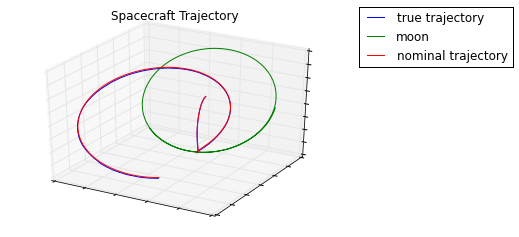

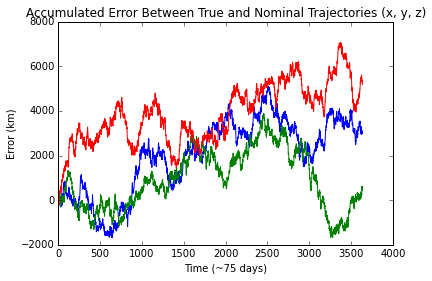

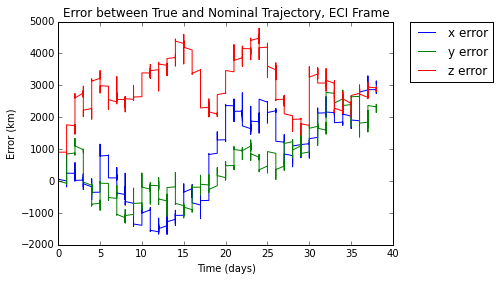

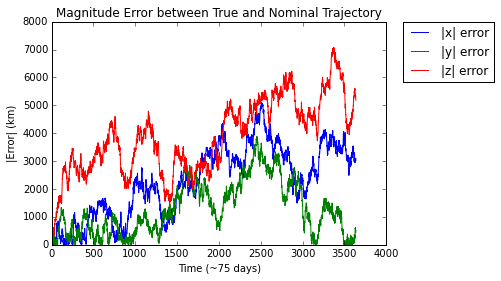

In [5]:
def STKTest(figs=True):
    a_t = numpy.arange(0, 1800*len(satx), 1800)
#     asol = integrate.odeint(statePropagate, [-1.501540312811781e4, -2.356897680091111e4,
#                                              2.241504923500546e3, -4.855378922082240e-1,
#                                              -5.048763191594085, -8.799883161637991e-1], a_t)
    
    asol = integrate.odeint(statePropagate, [-1.501540312811781e4, -2.356897680091111e4,
                                             2.241504923500546e3, -4.865378922082240e-1,
                                             -5.058763191594085, -8.809883161637991e-1], a_t)
    
    x, y, z, xt, yt, zt = [], [], [], [], [], []
    ex, ey, ez = [], [], []
    mx, my, mz = [], [], []
    xn, yn, zn = [], [], []
    for i in range(len(asol)):
        x.extend([asol[i][0]]); y.extend([asol[i][1]]); z.extend([asol[i][2]])
        ex.extend([asol[i][0] - satPos(a_t[i])[0]])
        ey.extend([asol[i][1] - satPos(a_t[i])[1]])
        ez.extend([asol[i][2] - satPos(a_t[i])[2]])
    for i in a_t:
        mx.extend([moonPos(i)[0]]); my.extend([moonPos(i)[1]]); mz.extend([moonPos(i)[2]])
        xt.extend([satPos(i)[0]]); yt.extend([satPos(i)[1]]); zt.extend([satPos(i)[2]])
        xn.extend([satPosNominal(i)[0]]); yn.extend([satPosNominal(i)[1]]); zn.extend([satPosNominal(i)[2]])
    
    if figs==True:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.plot(xt[0:1834], yt[0:1834], zt[0:1834], label='true trajectory')
        ax.plot(mx[0:1834], my[0:1834], mz[0:1834], label='moon')
        ax.plot(xn[0:1834], yn[0:1834], zn[0:1834], label='nominal trajectory')
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        plt.title('Spacecraft Trajectory')
        error = numpy.array([x[-1], y[-1], z[-1]]) - numpy.array([xt[-1], yt[-1], zt[-1]])
        print 'Total Accumulated Error: '+str(numpy.linalg.norm(error))+' km'
        plt.show()
        plt.plot(ex); plt.plot(ey); plt.plot(ez)
        plt.title('Accumulated Error Between True and Nominal Trajectories (x, y, z)')
        plt.xlabel('Time (~75 days)')
        plt.ylabel('Error (km)')
        plt.show()
        plt.plot(numpy.arange(0, 1834*1800, 1800)/(60*60*24),
                 (numpy.array(xn) - numpy.array(xt))[0:1834], label='x error')
        plt.plot(numpy.arange(0, 1834*1800, 1800)/(60*60*24),
                 (numpy.array(yn) - numpy.array(yt))[0:1834], label='y error')
        plt.plot(numpy.arange(0, 1834*1800, 1800)/(60*60*24),
                 (numpy.array(zn) - numpy.array(zt))[0:1834], label='z error')
        plt.title('Error between True and Nominal Trajectory, ECI Frame')
        plt.xlabel('Time (days)')
        plt.ylabel('Error (km)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
        plt.plot(abs(numpy.array(xn) - numpy.array(xt)), label='|x| error')
        plt.plot(abs(numpy.array(yn) - numpy.array(yt)), label='|y| error')
        plt.plot(abs(numpy.array(zn) - numpy.array(zt)), label='|z| error')
        plt.title('Magnitude Error between True and Nominal Trajectory')
        plt.xlabel('Time (~75 days)')
        plt.ylabel('|Error| (km)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
    return [xt, yt, zt]

STKTest();


This trajectory has an unmodeled deltaV every 30 min of up to 90 m/s. That number is, in reality, much higher than would be expected in a practical application, but it serves to demonstrate the robustness of the Gauss-Newton iteration.

We assume that thruster mismodeling and misalignment lead to white stochastic unmodeled acceleration between timesteps.

All of these dynamics are in the ECI frame.

### The Gauss-Newton Measurement Model

Declare some constants

In [6]:
# Angular field of view of the camera (rad)
Theta = 0.872664626

# Pixel width of the camera (pixels)
P = 2500

# Pixel size (m)
sp = 1.4e-6

# Focal length (m)
lam = 3.6e-3

# radius of Earth, Sun, and Moon (km)
de = 6.371e3
dm = 1737.53
ds = 6.963e5

# Number of photos gathered in rapid succession
numsnaps=10

# Time between rapidly gathered photos
snaptime=0.1

Represent the positions of the Earth, Sun, and Moon relative to the spacecraft in terms of the known ephemerides of each celestial body. The positions of the Sun and Moon are represented in terms of the position of the Earth, which is the vector of interest.

\begin{align}
\underline{\bf{r}}_{ce} &= \left< x,y,z \right>\\
\underline{\bf{r}}_{cm} &= \left< x+d_{mx},y+d_{my},z+d_{mz}\right>\\
\underline{\bf{r}}_{cs} &= \left< x+d_{sx},y+d_{sy},z+d_{sz} \right>
\end{align}

$d_{mx}$, $d_{my}$, and $d_{mz}$ are the coordinates of the Moon in the ECI frame; and $d_{sx}$, $d_{sy}$, and $d_{sz}$ are the coordinates of the Sun in the ECI frame. All of these are parameters that can be looked up directly from the ephemerides (see function below). The unit vector from the spacecraft to each celestial body is then given by:

In [7]:
def gaussOffsets(t):
    dmx, dmy, dmz = moonPos(t)[0], moonPos(t)[1], moonPos(t)[2]
    dsx, dsy, dsz = sunPos(t)[0], sunPos(t)[1], sunPos(t)[2]
    return [dmx, dmy, dmz, dsx, dsy, dsz]

\begin{align}
{\bf{\underline{\hat{r}}}}_{ce} &= \left< \frac{x}{\left(x^{2}+y^{2}+z^{2}\right)^{\frac{1}{2}}}, \frac{y}{\left(x^{2}+y^{2}+z^{2}\right)^{\frac{1}{2}}}, \frac{z}{\left(x^{2}+y^{2}+z^{2}\right)^{\frac{1}{2}}} \right>\\
{\bf{\underline{\hat{r}}}}_{cm} &= \left< \frac{x+d_{mx}}{\left((x+d_{mx})^{2}+(y+d_{my})^{2}+(z+d_{mz})^{2}\right)^{\frac{1}{2}}}, \frac{y+d_{my}}{\left((x+d_{mx})^{2}+(y+d_{my})^{2}+(z+d_{mz})^{2}\right)^{\frac{1}{2}}}, \frac{z+d_{mz}}{\left((x+d_{mx})^{2}+(y+d_{my})^{2}+(z+d_{mz})^{2}\right)^{\frac{1}{2}}} \right>\\
{\bf{\underline{\hat{r}}}}_{cs} &= \left< \frac{x+d_{sx}}{\left((x+d_{sx})^{2}+(y+d_{sy})^{2}+(z+d_{sz})^{2}\right)^{\frac{1}{2}}}, \frac{y+d_{sy}}{\left((x+d_{sx})^{2}+(y+d_{sy})^{2}+(z+d_{sz})^{2}\right)^{\frac{1}{2}}}, \frac{z+d_{sz}}{\left((x+d_{sx})^{2}+(y+d_{sy})^{2}+(z+d_{sz})^{2}\right)^{\frac{1}{2}}} \right>
\end{align}

In order to obtain the cosines of the angles between each of these unit vectors (the quantity that we actuallly measure), we simply dot them. Doing so yields the following equations:

\begin{align}
z_{1} = \cos{\theta_{ecm}} = \left[\frac{x d_{\text{mx}}+y d_{\text{my}}+z d_{\text{mz}}+x^2+y^2+z^2}{\sqrt{x^2+y^2+z^2} \sqrt{\left(d_{\text{mx}}+x\right){}^2+\left(d_{\text{my}}+y\right){}^2+\left(d_{\text{mz}}+z\right){}^2}}\right] = h_{1}({\bf{\underline{x}}})
\end{align}

\begin{align}
z_{2}=\cos{\theta_{ecs}} = \left[\frac{x d_{\text{sx}}+y d_{\text{sy}}+z d_{\text{sz}}+x^2+y^2+z^2}{\sqrt{x^2+y^2+z^2} \sqrt{\left(d_{\text{sx}}+x\right){}^2+\left(d_{\text{sy}}+y\right){}^2+\left(d_{\text{sz}}+z\right){}^2}}\right] = h_{2}\left(\underline{\bf{x}}\right)
\end{align}

\begin{align}
z_{3} = \cos{\theta_{mcs}} = \left[\frac{d_{\text{mx}} \left(d_{\text{sx}}+x\right)+d_{\text{my}} \left(d_{\text{sy}}+y\right)+d_{\text{sz}} \left(d_{\text{mz}}+z\right)+z d_{\text{mz}}+x d_{\text{sx}}+y d_{\text{sy}}+x^2+y^2+z^2}{\sqrt{\left(d_{\text{mx}}+x\right){}^2+\left(d_{\text{my}}+y\right){}^2+\left(d_{\text{mz}}+z\right){}^2} \sqrt{\left(d_{\text{sx}}+x\right){}^2+\left(d_{\text{sy}}+y\right){}^2+\left(d_{\text{sz}}+z\right){}^2}}\right] = h_{3}\left(\underline{\bf{x}}\right)
\end{align}

Where $z_{1,2,3}$ are all constrained to $[-1,1]$. It is tempting to also include sine measurements, but these are impossible to include without first solving the attitude determination problem. The cosine is agnostic to the sign of the angle, while the sine is not. Unless the attitude determination problem is solved first, the only available information is the magnitudes of the angles. We also have width measurements of each celestial body, which lead to distance measurements. These distance measurements relate to the states according to the following equations (the Sun width measurement is omitted, because it provides no information in cislunar space):

\begin{align}
z_{4} &= \theta_{e} = 2\tan^{-1}{\left(\frac{d_{e}}{\sqrt{x^{2}+y^{2}+z^{2}}}\right)} = h_{4}({\bf{\underline{x}}})\\
z_{5} &= \theta_{m} = 2\tan^{-1}{\left(\frac{d_{m}}{\sqrt{(x+d_{mx})^{2}+(y+d_{my})^{2}+(z+d_{mz})^{2}}}\right)}  = h_{5}({\bf{\underline{x}}})
\end{align}

In [8]:
def gaussh(xarray, t):
    x, y, z = xarray[0][0], xarray[1][0], xarray[2][0]
    offsets = gaussOffsets(t)
    dmx, dmy, dmz = offsets[0], offsets[1], offsets[2]
    dsx, dsy, dsz = offsets[3], offsets[4], offsets[5]
    
    h1 = ((x*dmx + y*dmy + z*dmz + x**2. + y**2. + z**2.)/
          (numpy.sqrt(x**2. + y**2. + z**2.)*
           numpy.sqrt((dmx+x)**2. + (dmy+y)**2. + (dmz+z)**2.)))
    
    h2 = ((x*dsx + y*dsy + z*dsz + x**2. + y**2. + z**2.)/
          (numpy.sqrt(x**2. + y**2. + z**2.)*
           numpy.sqrt((dsx+x)**2. + (dsy+y)**2. + (dsz+z)**2.)))
    
    h3 = ((dmx*(dsx+x) + dmy*(dsy+y) + dsz*(dmz+z) + z*dmz + x*dsx + y*dsy + x**2. + y**2. + z**2.)/
          (numpy.sqrt((x+dmx)**2. + (y+dmy)**2. + (z+dmz)**2.)*
           numpy.sqrt((x+dsx)**2. + (y+dsy)**2. + (z+dsz)**2.)))
    
    h4 = 2.*numpy.arctan(de/numpy.sqrt(x**2. + y**2. + z**2.))
    
    h5 = 2.*numpy.arctan(dm/numpy.sqrt((x+dmx)**2. + (y+dmy)**2. + (z+dmz)**2.))
    
    return numpy.array([[h1, h2, h3, h4, h5]]).T

In [9]:
def gausshConstruct(xarray, t, snaps=numsnaps, dt=snaptime):
    h = gaussh(xarray, t)
    for i in range(1,snaps-1):
        h = numpy.vstack((h, gaussh(xarray, t+i*dt)))
    return h

There are two positions in space, one above the plane formed by the Earth, Sun and Moon; and one symmetrically below the plane formed by the Earth Sun and Moon, that agree with any set of distance and angular separation measurements. The Gauss-Newton method will converge to whichever side of the plane the initial guess places it on, but the EKF will use dynamics to determine the proper $z$.

Encapsulating all of this into vector form, we have ${\bf{\underline{z}}} = \underline{h}(\bf{\underline{x}})$. There will of course also be noise in our measurements. The error in these cosine measurements stems from error in unit vector measurements to the center of each celestial body. The error in unit vector measurements stem from error in centroid determination. We can therefore solve for the error covariance matrix for the cosine measurements:

\begin{align}
E_{centroid} = \mathcal{N}(0, \delta^{2})\text{ (measured in pixels)} = \mathcal{N}(0, s_{p}^{2}\delta^{2}) \text{ (measured in meters)}
\end{align}

Assuming a known camera field of view and pixel resolution, we can transform the above pixel error into angular measurement error.

\begin{align}
E_{angular} = \frac{\Theta}{P}\mathcal{N}\left( 0, \delta^{2}\right) = \mathcal{N}\left( 0, \frac{\delta^{2}\Theta^{2}}{P^{2}}\right)
\end{align}

Where $P$ is the pixel resolution of the camera, and $\Theta$ is the field of view in radians.

Assuming independence, the measurement error of the angle between two independent unit vectors, therefore, will be given by $\mathcal{N}\left( 0, \frac{2\delta^{2}\Theta^{2}}{P^{2}}\right)$. We can use this information to determine error in the cosine measurements (which, for now, we will assume are all independent).

\begin{align}
\cos{(\theta_{m} + \delta \theta)} &= \cos{\theta_{m}}\cos{\delta \theta} + \sin{\theta_{m}}\sin{\delta \theta}\\
&\approx \cos{\theta_{m}} + \delta \theta \sin{\theta_{m}}
\end{align}

The sin of the angle is not directly observable. Instead, it is ascertained from the cosine measurement.

\begin{align}
\cos{(\theta_{m} + \delta \theta)} &= \cos{\theta_{m}} + \delta \theta \left[ \pm \sqrt{1 -  \cos^{2}{\theta_{m}}} \right]\\
&=\cos{\theta_{m}} + \mathcal{N}\left( 0, \frac{2\delta^{2}\Theta^{2}}{P^{2}}\right) \left[ \pm \sqrt{1 -  \cos^{2}{\theta_{m}}} \right]\\
&=\cos{\theta_{m}} + \mathcal{N}\left( 0, \left[1-\cos^{2}{\theta_{m}}\right]\frac{2\delta^{2}\Theta^{2}}{P^{2}}\right)
\end{align}

Because the cosine is constrained to [-1,1], the noise term decreases to zero at these limits in order to prevent illegal cosines. At first glance, this seems wrong. If we were measuring angle, then the error would not care about the relative positions of the two planets being measured. No matter the relative positions of the planets, the expected angle measurement would be the same. We aren't measuring angle, however. We're measuring the cosine of the angle. At $\theta = 0,\pi$, angle error in either direction yields the same cosine measurement. The same is not true at $\frac{\pi}{2}$, for instance, where error in one direction gives a positive cosine, and error in the other direction gives negative cosines.

\begin{align}
R(\underline{z}) = \begin{bmatrix}
\frac{2\delta^{2}\Theta^{2}}{P^{2}}\left[1 - z^{2}_{1} \right] & 0 & 0 & 0 & 0\\
0 &  \frac{2\delta^{2}\Theta^{2}}{P^{2}}\left[1 - z^{2}_{2} \right] & 0 & 0 & 0\\
0 & 0 &  \frac{2\delta^{2}\Theta^{2}}{P^{2}}\left[1 - z^{2}_{3} \right] & 0 & 0\\
0 & 0 & 0 & \frac{\delta^{2}\Theta^{2}}{P^{2}} & 0\\
0 & 0 & 0 & 0 & \frac{\delta^{2}\Theta^{2}}{P^{2}}
\end{bmatrix}
\end{align}

In [10]:
def gaussR(z, delta):
    ident = numpy.eye(len(z))
    zmat = numpy.zeros((len(z), len(z)))
    for i in range(len(z)):
        zmat[i][i] = z[i]**2
    Rmat = (ident - zmat)*(((delta**2)*Theta**2)/(P**2))
    j=4
    while j<=len(z):
        Rmat[j][j] = delta**2.
        Rmat[j-1][j-1] = delta**2.
        j+=5
    return Rmat


(Note: I am assuming independence, but I believe there is some cross-coupling). We can now estimate $\bf{\underline{x}}$ by minimizing the following nonlinear cost function:

\begin{align}
J_{NLLSQ}({\bf{\underline{x}}}) = \frac{1}{2}\left[ {\bf{\underline{z}}} - {\underline{h}}({\bf{\underline{x}}}) \right]^{T} R^{-1} \left[ {\bf{\underline{z}}} - {\underline{h}}({\bf{\underline{x}}}) \right]
\end{align}

For convenience, let us transform this problem into a form where the measurement noise covariance equals the identity matrix. We do this by taking a Cholesky factorization of $R$ (which is easy in this case, since $R$ is diagonal).

\begin{align}
R = R_{a}^{T}R_{a} &\longrightarrow R_{a} = \begin{bmatrix}
\sqrt{\frac{2\delta^{2}\Theta^{2}}{P^{2}}\left[1 - z^{2}_{1} \right]} & 0 & 0 & 0 & 0\\
0 &  \sqrt{\frac{2\delta^{2}\Theta^{2}}{P^{2}}\left[1 - z^{2}_{2} \right]} & 0 & 0 & 0\\
0 & 0 &  \sqrt{\frac{2\delta^{2}\Theta^{2}}{P^{2}}\left[1 - z^{2}_{3} \right]} & 0 & 0\\
0 & 0 & 0 & \sqrt{\frac{\delta^{2} \Theta^{2}}{P^{2}}} & 0\\
0 & 0 & 0 & 0 & \sqrt{\frac{\delta^{2} \Theta^{2}}{P^{2}}}
\end{bmatrix}\\
&\longrightarrow 
R_{a}^{-T} = \begin{bmatrix}
\frac{1}{\sqrt{\frac{2\delta^{2}\Theta^{2}}{P^{2}}\left[1 - z^{2}_{1} \right]}} & 0 & 0 & 0 & 0\\
0 &  \frac{1}{\sqrt{\frac{2\delta^{2}\Theta^{2}}{P^{2}}\left[1 - z^{2}_{2} \right]}} & 0 & 0 & 0\\
0 & 0 &  \frac{1}{\sqrt{\frac{2\delta^{2}\Theta^{2}}{P^{2}}\left[1 - z^{2}_{3} \right]}} & 0 & 0\\
0 & 0 & 0 & \sqrt{\frac{P^{2}}{\delta^{2} \Theta^{2}}} & 0\\
0 & 0 & 0 & 0 & \sqrt{\frac{P^{2}}{\delta^{2} \Theta^{2}}}
\end{bmatrix}
\end{align}

Let us define the following new variables:

\begin{align}
{\bf{\underline{z}}}_{a} = R_{a}^{-T}{\bf{\underline{z}}} && {\underline{h}}_{a} = R_{a}^{-T}{\underline{h}}({\bf{\underline{x}}}) && {\bf{\underline{w}}}_{a} = R_{a}^{-T}{\bf{\underline{w}}}
\end{align}

In [11]:
def gaussTransform(mat, z, delta):
    return numpy.dot(pinv(numpy.linalg.cholesky(gaussR(z, delta))).T, mat)

In [12]:
preAttitude = False

def getPerfectMeasurements(t):
    """Takes the true spacecraft position (in ECI), multiplies
    it by -1 (since measurement is spacecraft --> Earth), and
    hits it with a random rotation matrix (since spacecraft has
    some arbitrary attitude). Returns measurements in spacecraft
    body frame to the Earth, Moon, and Sun. No noise."""
    mat = Rots.random_rotation_matrix()
    if preAttitude:
        mat = numpy.eye(3)
    earth = numpy.array([numpy.dot(mat, -1*satPos(t))]).T
    moon = numpy.array([numpy.dot(mat, -1*satPos(t) + moonPos(t))]).T
    sun = numpy.array([numpy.dot(mat, -1*satPos(t) + sunPos(t))]).T
    return numpy.concatenate((earth, moon, sun), axis=1)


def vecsToRaw(meas, delta):
    """Converts perfect vector measurements to perfect pixel measurements,
    and adds the amount of noise specified by delta (since noise enters
    via the pixel measurements)"""
    widths = [(P/Theta)*2*numpy.arctan(de/numpy.linalg.norm(meas[:,0])) + numpy.random.normal(0., delta),
              (P/Theta)*2*numpy.arctan(dm/numpy.linalg.norm(meas[:,1])) + numpy.random.normal(0., delta),
              (P/Theta)*2*numpy.arctan(ds/numpy.linalg.norm(meas[:,2])) + numpy.random.normal(0., delta)]
    for i in widths[0:3]:
        if i>P:
            i = P
    uvecs = [meas[:,0]/numpy.linalg.norm(meas[:,0]),
             meas[:,1]/numpy.linalg.norm(meas[:,1]),
             meas[:,2]/numpy.linalg.norm(meas[:,2])]
    for i in range(len(uvecs)):
        uvecs[i] = numpy.array(uvecs[i])
        axis = numpy.array([numpy.random.randn(),
                            numpy.random.randn(),
                            numpy.random.randn()])
        axis = axis/numpy.linalg.norm(axis)
        angle = numpy.random.normal(0, (delta*sp)/lam)
        uvecs[i] = (numpy.dot(Rots.rotation_matrix(axis, angle), uvecs[i])/
                    numpy.linalg.norm(numpy.dot(Rots.rotation_matrix(axis, angle), uvecs[i])))
        
    widths.extend(uvecs)
    return widths


def rawToVecs(raw, t):
    """Converts raw pixel measurements back into vectors"""
    earth = (de/(numpy.tan((Theta*raw[0])/(2*P)))) * raw[3]
    moon = (dm/(numpy.tan((Theta*raw[1])/(2*P)))) * raw[4]
    sun = (ds/(numpy.tan((Theta*raw[2])/(2*P)))) * raw[5]
    if preAttitude:
        sun = .5*((earth + sunPos(t)) + (moon + sunPos(t) - moonPos(t)))
    earth, moon, sun = numpy.array([earth]).T, numpy.array([moon]).T, numpy.array([sun]).T
    return numpy.concatenate((earth, moon, sun), axis=1)


def MeastoEphemeralTransform(measurements):
    """Takes measurements, and uses those measurements to create
    the rotation matrix that takes the measurements into the
    ephemeral frame."""
    for i in measurements:
        i = numpy.array(i)
    ex = numpy.array((measurements[:,1] - measurements[:,0]) /
                     numpy.linalg.norm(measurements[:,1] - measurements[:,0]))
    ez = numpy.array(numpy.cross(ex, (measurements[:,2] - measurements[:,0])) /
                      numpy.linalg.norm(numpy.cross(ex,(measurements[:,2] - measurements[:,0]))))
    ey = numpy.cross(ez, ex)/numpy.linalg.norm(numpy.cross(ez, ex))
    ex, ey, ez = numpy.array([ex]).T, numpy.array([ey]).T, numpy.array([ez]).T
    return numpy.concatenate((ex, ey, ez), axis=1).T


def ECItoEphemeralTransform(t):
    """For a given set of planet positions, returns the
    rotation matrix to the ephemeral frame from ECI"""
    ex = moonPos(t)/numpy.linalg.norm(moonPos(t))
    ez = numpy.cross(ex, sunPos(t))/numpy.linalg.norm(numpy.cross(ex, sunPos(t)))
    ey = numpy.cross(ez, ex)/numpy.linalg.norm(numpy.cross(ez, ex))
    ex, ey, ez = numpy.array([ex]).T, numpy.array([ey]).T, numpy.array([ez]).T
    return numpy.concatenate((ex, ey, ez), axis=1).T


def MeastoECI(measurements, t):
    """Converts from spacecraft body to ECI frame, via the 
    Ephemeral frame."""
    if preAttitude:
        return numpy.eye(3)
    return numpy.dot(ECItoEphemeralTransform(t).T, MeastoEphemeralTransform(measurements))

def gaussMeas(t, delta):
    body = getPerfectMeasurements(t)
    raw = vecsToRaw(body, delta)
    vecs = rawToVecs(raw, t)
    earth, moon, sun = vecs[:,0], vecs[:,1], vecs[:,2]
    De, Dm, Ds = numpy.linalg.norm(earth), numpy.linalg.norm(moon), numpy.linalg.norm(sun)
    cecm = numpy.dot(earth/De, (moon.T)/Dm)
    cecs = numpy.dot(earth/De, (sun.T)/Ds)
    cmcs = numpy.dot(moon/Dm, (sun.T)/Ds)
    if cecm > 1.:
        cecm = 1.
    if cecs > 1.:
        cecs = 1.
    if cmcs > 1.:
        cmcs = 1.
    if cecm < -1.:
        cecm = -1.
    if cecs < -1.:
        cecs = -1.
    if cmcs < -1:
        cmcs = -1.
    we, wm = raw[0]*(Theta/P), raw[1]*(Theta/P)
        
    return numpy.array([[cecm, cecs, cmcs, we, wm]]).T

In [13]:
def gaussMeasConstruct(t, delta, snaps=numsnaps, dt=snaptime):
    meas = gaussMeas(t, delta)
    for i in range(1, snaps-1):
        meas = numpy.vstack((meas, gaussMeas(t+i*dt, delta)))
    return meas

Observe the measurements and their one sigma deviations over the course of the trajectory.

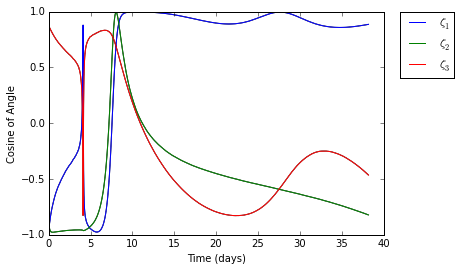

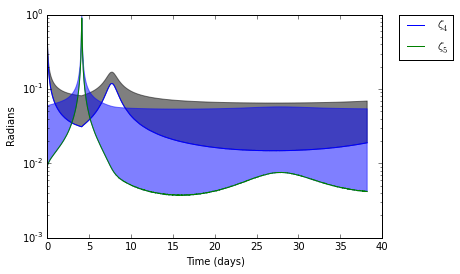

In [14]:
def rawMeasVis():
    testc1, testc2, testc3, testw1, testw2 = [], [], [], [], []
    rvar1, rvar2, rvar3, rvar4, rvar5 = [], [], [], [], []
    for i in numpy.arange(0, 1800*1835, 1800):
        testmeas = gaussMeas(i, delta=0.05)
        rtest = gaussR(testmeas, delta=0.05)
        testc1.extend([testmeas[0][0]])
        testc2.extend([testmeas[1][0]])
        testc3.extend([testmeas[2][0]])
        testw1.extend([testmeas[3][0]])
        testw2.extend([testmeas[4][0]])
        rvar1.extend([numpy.sqrt(rtest[0][0])])
        rvar2.extend([numpy.sqrt(rtest[1][1])])
        rvar3.extend([numpy.sqrt(rtest[2][2])])
        rvar4.extend([numpy.sqrt(rtest[3][3])])
        rvar5.extend([numpy.sqrt(rtest[4][4])])
    plt.plot(numpy.arange(0,1800*1835, 1800.)/(60*60*24),
             testc1, label='$\zeta_{1}$')
    plt.plot(numpy.arange(0,1800*1835, 1800.)/(60*60*24),
             testc2, label='$\zeta_{2}$')
    plt.plot(numpy.arange(0,1800*1835, 1800.)/(60*60*24),
             testc3, label='$\zeta_{3}$')
    plt.fill_between(numpy.arange(0, 1800*1835, 1800.)/(60*60*24),
                     numpy.array(testc1)+3.*numpy.array(rvar1),
                     numpy.array(testc1)-3.*numpy.array(rvar1), color='k',alpha=.5)
    plt.fill_between(numpy.arange(0, 1800*1835, 1800.)/(60*60*24),
                     numpy.array(testc2)+3.*numpy.array(rvar2),
                     numpy.array(testc2)-3.*numpy.array(rvar2), color='k',alpha=.5)
    plt.fill_between(numpy.arange(0, 1800*1835, 1800.)/(60*60*24),
                     numpy.array(testc3)+3.*numpy.array(rvar3),
                     numpy.array(testc3)-3.*numpy.array(rvar3), color='k',alpha=.5)
#     plt.title('Cosine Measurements')
    plt.xlabel('Time (days)')
    plt.ylabel('Cosine of Angle')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    plt.plot(numpy.arange(0,1800*1835, 1800.)/(60*60*24),
             testw1, label='$\zeta_{4}$')
    plt.plot(numpy.arange(0,1800*1835, 1800.)/(60*60*24),
             testw2, label='$\zeta_{5}$')
    plt.fill_between(numpy.arange(0, 1800*1835, 1800.)/(60*60*24),
                     numpy.array(testw1)+1.*numpy.array(rvar4),
                     numpy.array(testw1), color='k',alpha=.5)
    plt.fill_between(numpy.arange(0, 1800*1835, 1800.)/(60*60*24),
                     numpy.array(testw2)+1.*numpy.array(rvar5),
                     numpy.array(testw2), color='b',alpha=.5)
#     plt.title('Angular Width Measurements')
    plt.xlabel('Time (days)')
    plt.ylabel('Radians')
    plt.yscale('log')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
rawMeasVis()

Under these transformations, the cost function becomes:

\begin{align}
J_{NLLS}({\bf{\underline{x}}}) = \frac{1}{2}\left[ {\bf{\underline{z}}}_{a} - {\underline{h}}_{a}({\bf{\underline{x}}}) \right]^{T} \left[ {\bf{\underline{z}}}_{a} - {\underline{h}}_{a}({\bf{\underline{x}}}) \right]
\end{align}

The below functions track the cost and covariance so that we can monitor convergence.

In [21]:
def Jnlls(xarray, z, t, delta):
    return .5*numpy.dot(numpy.dot((z - gausshConstruct(xarray, t)).T, pinv(gaussR(z, delta))),
                        z - gausshConstruct(xarray, t))[0][0]

The covariance is given by (approximately) $P=(H^{T}H)^{-1}$

In [22]:
def gaussP(xarray, z, t, delta):
    return pinv(numpy.dot(gaussTransform(HBuildConstruct(xarray, t), z, delta).T,
                         gaussTransform(HBuildConstruct(xarray, t), z, delta)))

The goal now is to find the ${\bf{\underline{x}}}$ which minimizes this function using Gauss-Newton iteration. Dropping the $a$ subscript for convenience, the first-order necessary condition for $J_{NLLS}({\bf{\underline{x}}})$ optimality is given by:

\begin{align}
{\bf{\underline{0}}} = \begin{bmatrix}\frac{\partial{J_{NLLS}}}{\partial{{\bf{\underline{x}}}}}\end{bmatrix}^{T} = \left[ {\bf{\underline{z}}} - \underline{h}({\bf{\underline{x}}})\right]^{T} \left[ -\frac{\partial{\underline{h}}}{\partial{\bf{\underline{x}}}}\right] = -\left[ {\bf{\underline{z}}} - \underline{h}({\bf{\underline{x}}})\right]^{T} H
\end{align}

With no prior knowledge, we would have a huge searchspace to traverse in order to find the absolute minimum. However, we can give an initial guess based on the lousy distance measurements. A hillclimber can then be used to climb to the local extremum in the vicinity of the initial guess. Beginning with an initial guess ${\bf{\underline{\hat{x}}}}_{g}$, we solve:

\begin{align}
0 = \underline{\mathcal{f}}({\bf{\underline{\hat{x}}}}_{g} + \underline{\Delta}{\bf{\hat{x}}}_{g}) \approx \underline{\mathcal{f}}({\bf{\underline{\hat{x}}}}_{g}) + \left[ \frac{\partial{\underline{f}}}{\partial{{\bf{\underline{x}}}}} \right]_{{\bf{\underline{\hat{x}}}}_{g}}\Delta {\bf{\underline{x}}}
\end{align}

Which gives

\begin{align}
\Delta {\bf{\underline{x}}} = -\left[ \frac{\partial{\mathcal{\underline{f}}}}{\partial{\bf{\underline{x}}}} \right]^{-1} \mathcal{\underline{f}}({\bf{\underline{\hat{x}}}}_{g})
\end{align}

We can then form the new guess ${\bf{\hat{\underline{x}}}}_{g new} = {\bf{\hat{\underline{x}}}}_{g} + \Delta {\bf{\underline{\hat{x}}}}$ and repeat the above process. In our particular case, we have:

\begin{align}
\frac{\partial{\mathcal{\underline{f}}}}{\partial{\bf{\underline{x}}}} = -\frac{\partial{(H^{T})}}{\partial{\bf{\underline{x}}}} \left[ {\bf{\underline{z}}} - \underline{h}({\bf{\underline{x}}}) \right] + H^{T}({\bf{\underline{x}}}) \frac{\partial{\underline{h}}}{\partial{\bf{\underline{x}}}} = V
\end{align}

However, if our initial guess places us near the optimum, then ${\bf{\underline{z}}} - \underline{h}({\bf{\underline{x}}}) \approx 0$ and the above expression reduces to:

\begin{align}
\frac{\partial{\mathcal{\underline{f}}}}{\partial{\bf{\underline{x}}}} \approx H^{T}H = V
\end{align}

Which allows us to rewrite the equation for $\Delta {\bf{\underline{x}}}$ as:

\begin{align}
\Delta {\bf{\underline{x}}} &= V^{-1}\left\{ H^{T}\left[ {\bf{\underline{z}}} - \underline{h}({\bf{\underline{\hat{x}}}}_{g})\right] \right\}\\
&= \tilde{R}^{-1}\tilde{Q}^{T}\left[\underline{z}_{a} - \underline{h}_{a}(\underline{x})\right]\\ &=  \left(H_{a}^{T}H_{a}\right)^{-1}H_{a}^{T}\left[\underline{z}_{a} - \underline{h}_{a}(\underline{x})\right]
\end{align}

The below functions take the necessary QR decomposition.

In [23]:
def QRr(mat):
    q, r = numpy.linalg.qr(mat)
    return r

def QRq(mat):
    q, r = numpy.linalg.qr(mat)
    return q

The above expressions require $H$, the Jacobian of the nonlinear measurement equations with respect to each state variable. Let us now calculate those partial derivatives. The first row:

\begin{align}
\frac{\partial{h_{1}}}{\partial{x}} &= \frac{\left(d_{\text{mx}}+x\right) \left(-\left(x^2+y^2+z^2\right)\right) \left(x d_{\text{mx}}+y d_{\text{my}}+z d_{\text{mz}}+x^2+y^2+z^2\right)+\left(d_{\text{mx}}+2 x\right) \left(x^2+y^2+z^2\right) \left(\left(d_{\text{mx}}+x\right){}^2+\left(d_{\text{my}}+y\right){}^2+\left(d_{\text{mz}}+z\right){}^2\right)-x \left(x \left(d_{\text{mx}}+x\right)+y \left(d_{\text{my}}+y\right)+z \left(d_{\text{mz}}+z\right)\right) \left(\left(d_{\text{mx}}+x\right){}^2+\left(d_{\text{my}}+y\right){}^2+\left(d_{\text{mz}}+z\right){}^2\right)}{\left(x^2+y^2+z^2\right)^{3/2} \left(\left(d_{\text{mx}}+x\right){}^2+\left(d_{\text{my}}+y\right){}^2+\left(d_{\text{mz}}+z\right){}^2\right){}^{3/2}}\\
\frac{\partial{h_{1}}}{\partial{y}} &= \frac{\left(d_{\text{my}}+y\right) \left(-\left(x^2+y^2+z^2\right)\right) \left(x d_{\text{mx}}+y d_{\text{my}}+z d_{\text{mz}}+x^2+y^2+z^2\right)+\left(d_{\text{my}}+2 y\right) \left(x^2+y^2+z^2\right) \left(\left(d_{\text{mx}}+x\right){}^2+\left(d_{\text{my}}+y\right){}^2+\left(d_{\text{mz}}+z\right){}^2\right)-y \left(x \left(d_{\text{mx}}+x\right)+y \left(d_{\text{my}}+y\right)+z \left(d_{\text{mz}}+z\right)\right) \left(\left(d_{\text{mx}}+x\right){}^2+\left(d_{\text{my}}+y\right){}^2+\left(d_{\text{mz}}+z\right){}^2\right)}{\left(x^2+y^2+z^2\right)^{3/2} \left(\left(d_{\text{mx}}+x\right){}^2+\left(d_{\text{my}}+y\right){}^2+\left(d_{\text{mz}}+z\right){}^2\right){}^{3/2}}\\
\frac{\partial{h_{1}}}{\partial{z}} &= \frac{\left(d_{\text{mz}}+z\right) \left(-\left(x^2+y^2+z^2\right)\right) \left(x d_{\text{mx}}+y d_{\text{my}}+z d_{\text{mz}}+x^2+y^2+z^2\right)+\left(d_{\text{mz}}+2 z\right) \left(x^2+y^2+z^2\right) \left(\left(d_{\text{mx}}+x\right){}^2+\left(d_{\text{my}}+y\right){}^2+\left(d_{\text{mz}}+z\right){}^2\right)-z \left(x \left(d_{\text{mx}}+x\right)+y \left(d_{\text{my}}+y\right)+z \left(d_{\text{mz}}+z\right)\right) \left(\left(d_{\text{mx}}+x\right){}^2+\left(d_{\text{my}}+y\right){}^2+\left(d_{\text{mz}}+z\right){}^2\right)}{\left(x^2+y^2+z^2\right)^{3/2} \left(\left(d_{\text{mx}}+x\right){}^2+\left(d_{\text{my}}+y\right){}^2+\left(d_{\text{mz}}+z\right){}^2\right){}^{3/2}}
\end{align}

In [24]:
def dh1_denom(xarray, t):
    x, y, z = xarray[0][0], xarray[1][0], xarray[2][0]
    offsets = gaussOffsets(t)
    dmx, dmy, dmz = offsets[0], offsets[1], offsets[2]
    dsx, dsy, dsz = offsets[3], offsets[4], offsets[5]
    return (((x**2. + y**2. + z**2.)**(3./2.))*
            (((dmx+x)**2. + (dmy+y)**2. + (dmz+z)**2.)**(3./2.)))

In [25]:
def dh1_num_template(xarray, t, a, b, c):
    x, y, z = xarray[0][0], xarray[1][0], xarray[2][0]
    offsets = gaussOffsets(t)
    dmx, dmy, dmz = offsets[0], offsets[1], offsets[2]
    dsx, dsy, dsz = offsets[3], offsets[4], offsets[5]
    return (a*(-(x**2. + y**2. + z**2.))*(x*dmx + y*dmy + z*dmz + x**2. + y**2. + z**2.) +
            b*(x**2. + y**2. + z**2.)*((dmx+x)**2. + (dmy+y)**2. + (dmz+z)**2.) -
            c*(x*(dmx+x) + y*(dmy+y) + z*(dmz+z))*((dmx+x)**2. + (dmy+y)**2. +(dmz+z)**2.))

In [26]:
def dh1_dx_num(xarray, t):
    x, y, z = xarray[0][0], xarray[1][0], xarray[2][0]
    offsets = gaussOffsets(t)
    dmx, dmy, dmz = offsets[0], offsets[1], offsets[2]
    dsx, dsy, dsz = offsets[3], offsets[4], offsets[5]
    return dh1_num_template(xarray, t, dmx+x, dmx+2.*x, x)

In [27]:
def dh1_dy_num(xarray, t):
    x, y, z = xarray[0][0], xarray[1][0], xarray[2][0]
    offsets = gaussOffsets(t)
    dmx, dmy, dmz = offsets[0], offsets[1], offsets[2]
    dsx, dsy, dsz = offsets[3], offsets[4], offsets[5]
    return dh1_num_template(xarray, t, dmy+y, dmy+2.*y, y)

In [28]:
def dh1_dz_num(xarray, t):
    x, y, z = xarray[0][0], xarray[1][0], xarray[2][0]
    offsets = gaussOffsets(t)
    dmx, dmy, dmz = offsets[0], offsets[1], offsets[2]
    dsx, dsy, dsz = offsets[3], offsets[4], offsets[5]
    return dh1_num_template(xarray, t, dmz+z, dmz+2.*z, z)

In [29]:
def dh1_row(xarray, t):
    denom = dh1_denom(xarray, t)
    return numpy.array([[dh1_dx_num(xarray, t)/denom,
                         dh1_dy_num(xarray, t)/denom,
                         dh1_dz_num(xarray, t)/denom]])

The second row:

\begin{align}
\frac{\partial{h_{2}}}{\partial{x}} &= \frac{\left(d_{\text{sx}}+x\right) \left(-\left(x^2+y^2+z^2\right)\right) \left(x d_{\text{sx}}+y d_{\text{sy}}+z d_{\text{sz}}+x^2+y^2+z^2\right)+\left(d_{\text{sx}}+2 x\right) \left(x^2+y^2+z^2\right) \left(\left(d_{\text{sx}}+x\right){}^2+\left(d_{\text{sy}}+y\right){}^2+\left(d_{\text{sz}}+z\right){}^2\right)-x \left(x \left(d_{\text{sx}}+x\right)+y \left(d_{\text{sy}}+y\right)+z \left(d_{\text{sz}}+z\right)\right) \left(\left(d_{\text{sx}}+x\right){}^2+\left(d_{\text{sy}}+y\right){}^2+\left(d_{\text{sz}}+z\right){}^2\right)}{\left(x^2+y^2+z^2\right)^{3/2} \left(\left(d_{\text{sx}}+x\right){}^2+\left(d_{\text{sy}}+y\right){}^2+\left(d_{\text{sz}}+z\right){}^2\right){}^{3/2}}\\
\frac{\partial{h_{2}}}{\partial{y}} &= \frac{\left(d_{\text{sy}}+y\right) \left(-\left(x^2+y^2+z^2\right)\right) \left(x d_{\text{sx}}+y d_{\text{sy}}+z d_{\text{sz}}+x^2+y^2+z^2\right)+\left(d_{\text{sy}}+2 y\right) \left(x^2+y^2+z^2\right) \left(\left(d_{\text{sx}}+x\right){}^2+\left(d_{\text{sy}}+y\right){}^2+\left(d_{\text{sz}}+z\right){}^2\right)-y \left(x \left(d_{\text{sx}}+x\right)+y \left(d_{\text{sy}}+y\right)+z \left(d_{\text{sz}}+z\right)\right) \left(\left(d_{\text{sx}}+x\right){}^2+\left(d_{\text{sy}}+y\right){}^2+\left(d_{\text{sz}}+z\right){}^2\right)}{\left(x^2+y^2+z^2\right)^{3/2} \left(\left(d_{\text{sx}}+x\right){}^2+\left(d_{\text{sy}}+y\right){}^2+\left(d_{\text{sz}}+z\right){}^2\right){}^{3/2}}\\
\frac{\partial{h_{2}}}{\partial{z}} &= \frac{\left(d_{\text{sz}}+z\right) \left(-\left(x^2+y^2+z^2\right)\right) \left(x d_{\text{sx}}+y d_{\text{sy}}+z d_{\text{sz}}+x^2+y^2+z^2\right)+\left(d_{\text{sz}}+2 z\right) \left(x^2+y^2+z^2\right) \left(\left(d_{\text{sx}}+x\right){}^2+\left(d_{\text{sy}}+y\right){}^2+\left(d_{\text{sz}}+z\right){}^2\right)-z \left(x \left(d_{\text{sx}}+x\right)+y \left(d_{\text{sy}}+y\right)+z \left(d_{\text{sz}}+z\right)\right) \left(\left(d_{\text{sx}}+x\right){}^2+\left(d_{\text{sy}}+y\right){}^2+\left(d_{\text{sz}}+z\right){}^2\right)}{\left(x^2+y^2+z^2\right)^{3/2} \left(\left(d_{\text{sx}}+x\right){}^2+\left(d_{\text{sy}}+y\right){}^2+\left(d_{\text{sz}}+z\right){}^2\right){}^{3/2}}\\
\end{align}

In [30]:
def dh2_denom(xarray, t):
    x, y, z = xarray[0][0], xarray[1][0], xarray[2][0]
    offsets = gaussOffsets(t)
    dmx, dmy, dmz = offsets[0], offsets[1], offsets[2]
    dsx, dsy, dsz = offsets[3], offsets[4], offsets[5]
    return (((x**2. + y**2. + z**2.)**(3./2.))*
            (((dsx+x)**2. + (dsy+y)**2. + (dsz+z)**2.)**(3./2.)))

In [31]:
def dh2_num_template(xarray, t, a, b, c):
    x, y, z = xarray[0][0], xarray[1][0], xarray[2][0]
    offsets = gaussOffsets(t)
    dmx, dmy, dmz = offsets[0], offsets[1], offsets[2]
    dsx, dsy, dsz = offsets[3], offsets[4], offsets[5]
    return (a*(-(x**2. + y**2. + z**2.))*(x*dsx + y*dsy + z*dsz + x**2. + y**2. + z**2.) +
            b*(x**2. + y**2. + z**2.)*((dsx+x)**2. + (dsy+y)**2. + (dsz+z)**2.) -
            c*(x*(dsx+x) + y*(dsy+y) + z*(dsz+z))*((dsx+x)**2. + (dsy+y)**2. +(dsz+z)**2.))

In [32]:
def dh2_dx_num(xarray, t):
    x, y, z = xarray[0][0], xarray[1][0], xarray[2][0]
    offsets = gaussOffsets(t)
    dmx, dmy, dmz = offsets[0], offsets[1], offsets[2]
    dsx, dsy, dsz = offsets[3], offsets[4], offsets[5]
    return dh2_num_template(xarray, t, dsx+x, dsx+2.*x, x)

In [33]:
def dh2_dy_num(xarray, t):
    x, y, z = xarray[0][0], xarray[1][0], xarray[2][0]
    offsets = gaussOffsets(t)
    dmx, dmy, dmz = offsets[0], offsets[1], offsets[2]
    dsx, dsy, dsz = offsets[3], offsets[4], offsets[5]
    return dh2_num_template(xarray, t, dsy+y, dsy+2.*y, y)

In [34]:
def dh2_dz_num(xarray, t):
    x, y, z = xarray[0][0], xarray[1][0], xarray[2][0]
    offsets = gaussOffsets(t)
    dmx, dmy, dmz = offsets[0], offsets[1], offsets[2]
    dsx, dsy, dsz = offsets[3], offsets[4], offsets[5]
    return dh2_num_template(xarray, t, dsz+z, dsz+2.*z, z)

In [35]:
def dh2_row(xarray, t):
    denom = dh2_denom(xarray, t)
    return numpy.array([[dh2_dx_num(xarray, t)/denom,
                         dh2_dy_num(xarray, t)/denom,
                         dh2_dz_num(xarray, t)/denom]])

The third row:

\begin{align}
\frac{\partial{h_{3}}}{\partial{x}} &= \frac{d_{\text{mx}}+d_{\text{sx}}+2 x}{\sqrt{\left(d_{\text{mx}}+x\right){}^2+\left(d_{\text{my}}+y\right){}^2+\left(d_{\text{mz}}+z\right){}^2} \sqrt{\left(d_{\text{sx}}+x\right){}^2+\left(d_{\text{sy}}+y\right){}^2+\left(d_{\text{sz}}+z\right){}^2}}-\frac{\left(d_{\text{mx}}+x\right) \left(\left(d_{\text{mx}}+x\right) \left(d_{\text{sx}}+x\right)+\left(d_{\text{my}}+y\right) \left(d_{\text{sy}}+y\right)+\left(d_{\text{mz}}+z\right) \left(d_{\text{sz}}+z\right)\right)}{\left(\left(d_{\text{mx}}+x\right){}^2+\left(d_{\text{my}}+y\right){}^2+\left(d_{\text{mz}}+z\right){}^2\right){}^{3/2} \sqrt{\left(d_{\text{sx}}+x\right){}^2+\left(d_{\text{sy}}+y\right){}^2+\left(d_{\text{sz}}+z\right){}^2}}-\frac{\left(d_{\text{sx}}+x\right) \left(\left(d_{\text{mx}}+x\right) \left(d_{\text{sx}}+x\right)+\left(d_{\text{my}}+y\right) \left(d_{\text{sy}}+y\right)+\left(d_{\text{mz}}+z\right) \left(d_{\text{sz}}+z\right)\right)}{\sqrt{\left(d_{\text{mx}}+x\right){}^2+\left(d_{\text{my}}+y\right){}^2+\left(d_{\text{mz}}+z\right){}^2} \left(\left(d_{\text{sx}}+x\right){}^2+\left(d_{\text{sy}}+y\right){}^2+\left(d_{\text{sz}}+z\right){}^2\right){}^{3/2}}\\
\frac{\partial{h_{3}}}{\partial{y}} &=\frac{d_{\text{my}}+d_{\text{sy}}+2 y}{\sqrt{\left(d_{\text{mx}}+x\right){}^2+\left(d_{\text{my}}+y\right){}^2+\left(d_{\text{mz}}+z\right){}^2} \sqrt{\left(d_{\text{sx}}+x\right){}^2+\left(d_{\text{sy}}+y\right){}^2+\left(d_{\text{sz}}+z\right){}^2}}-\frac{\left(d_{\text{my}}+y\right) \left(\left(d_{\text{mx}}+x\right) \left(d_{\text{sx}}+x\right)+\left(d_{\text{my}}+y\right) \left(d_{\text{sy}}+y\right)+\left(d_{\text{mz}}+z\right) \left(d_{\text{sz}}+z\right)\right)}{\left(\left(d_{\text{mx}}+x\right){}^2+\left(d_{\text{my}}+y\right){}^2+\left(d_{\text{mz}}+z\right){}^2\right){}^{3/2} \sqrt{\left(d_{\text{sx}}+x\right){}^2+\left(d_{\text{sy}}+y\right){}^2+\left(d_{\text{sz}}+z\right){}^2}}-\frac{\left(d_{\text{sy}}+y\right) \left(\left(d_{\text{mx}}+x\right) \left(d_{\text{sx}}+x\right)+\left(d_{\text{my}}+y\right) \left(d_{\text{sy}}+y\right)+\left(d_{\text{mz}}+z\right) \left(d_{\text{sz}}+z\right)\right)}{\sqrt{\left(d_{\text{mx}}+x\right){}^2+\left(d_{\text{my}}+y\right){}^2+\left(d_{\text{mz}}+z\right){}^2} \left(\left(d_{\text{sx}}+x\right){}^2+\left(d_{\text{sy}}+y\right){}^2+\left(d_{\text{sz}}+z\right){}^2\right){}^{3/2}}\\
\frac{\partial{h_{3}}}{\partial{z}} &= \frac{d_{\text{mz}}+d_{\text{sz}}+2 z}{\sqrt{\left(d_{\text{mx}}+x\right){}^2+\left(d_{\text{my}}+y\right){}^2+\left(d_{\text{mz}}+z\right){}^2} \sqrt{\left(d_{\text{sx}}+x\right){}^2+\left(d_{\text{sy}}+y\right){}^2+\left(d_{\text{sz}}+z\right){}^2}}-\frac{\left(d_{\text{mz}}+z\right) \left(\left(d_{\text{mx}}+x\right) \left(d_{\text{sx}}+x\right)+\left(d_{\text{my}}+y\right) \left(d_{\text{sy}}+y\right)+\left(d_{\text{mz}}+z\right) \left(d_{\text{sz}}+z\right)\right)}{\left(\left(d_{\text{mx}}+x\right){}^2+\left(d_{\text{my}}+y\right){}^2+\left(d_{\text{mz}}+z\right){}^2\right){}^{3/2} \sqrt{\left(d_{\text{sx}}+x\right){}^2+\left(d_{\text{sy}}+y\right){}^2+\left(d_{\text{sz}}+z\right){}^2}}-\frac{\left(d_{\text{sz}}+z\right) \left(\left(d_{\text{mx}}+x\right) \left(d_{\text{sx}}+x\right)+\left(d_{\text{my}}+y\right) \left(d_{\text{sy}}+y\right)+\left(d_{\text{mz}}+z\right) \left(d_{\text{sz}}+z\right)\right)}{\sqrt{\left(d_{\text{mx}}+x\right){}^2+\left(d_{\text{my}}+y\right){}^2+\left(d_{\text{mz}}+z\right){}^2} \left(\left(d_{\text{sx}}+x\right){}^2+\left(d_{\text{sy}}+y\right){}^2+\left(d_{\text{sz}}+z\right){}^2\right){}^{3/2}}
\end{align}

In [36]:
def dh3_term1_denom(xarray, t):
    x, y, z = xarray[0][0], xarray[1][0], xarray[2][0]
    offsets = gaussOffsets(t)
    dmx, dmy, dmz = offsets[0], offsets[1], offsets[2]
    dsx, dsy, dsz = offsets[3], offsets[4], offsets[5]
    return (numpy.sqrt((dmx+x)**2. + (dmy+y)**2. + (dmz+z)**2.)*
            numpy.sqrt((dsx+x)**2. + (dsy+y)**2. + (dsz+z)**2.))

In [37]:
def dh3_term2_denom(xarray, t):
    x, y, z = xarray[0][0], xarray[1][0], xarray[2][0]
    offsets = gaussOffsets(t)
    dmx, dmy, dmz = offsets[0], offsets[1], offsets[2]
    dsx, dsy, dsz = offsets[3], offsets[4], offsets[5]
    return -1.*((((dmx+x)**2. + (dmy+y)**2. + (dmz+z)**2.)**(3./2.))*
                numpy.sqrt((dsx+x)**2. + (dsy+y)**2. + (dsz+z)**2.))

In [38]:
def dh3_term3_denom(xarray, t):
    x, y, z = xarray[0][0], xarray[1][0], xarray[2][0]
    offsets = gaussOffsets(t)
    dmx, dmy, dmz = offsets[0], offsets[1], offsets[2]
    dsx, dsy, dsz = offsets[3], offsets[4], offsets[5]
    return -1.*(numpy.sqrt((dmx+x)**2. + (dmy+y)**2. + (dmz+z)**2.)*
                ((dsx+x)**2. + (dsy+y)**2. + (dsz+z)**2.)**(3./2.))

In [39]:
def dh3_term1_num_template(xarray, t, a, b, c):
    return a + b + 2*c

In [40]:
def dh3_term2_num_template(xarray, t, a):
    x, y, z = xarray[0][0], xarray[1][0], xarray[2][0]
    offsets = gaussOffsets(t)
    dmx, dmy, dmz = offsets[0], offsets[1], offsets[2]
    dsx, dsy, dsz = offsets[3], offsets[4], offsets[5]
    return a*((dmx+x)*(dsx+x) + (dmy+y)*(dsy+y) + (dmz+z)*(dsz+z))

In [41]:
def dh3_term3_num_template(xarray, t, a):
    x, y, z = xarray[0][0], xarray[1][0], xarray[2][0]
    offsets = gaussOffsets(t)
    dmx, dmy, dmz = offsets[0], offsets[1], offsets[2]
    dsx, dsy, dsz = offsets[3], offsets[4], offsets[5]
    return a*((dmx+x)*(dsx+x) + (dmy+y)*(dsy+y) + (dmz+z)*(dsz+z))

In [42]:
def dh3_dx(xarray, t):
    x, y, z = xarray[0][0], xarray[1][0], xarray[2][0]
    offsets = gaussOffsets(t)
    dmx, dmy, dmz = offsets[0], offsets[1], offsets[2]
    dsx, dsy, dsz = offsets[3], offsets[4], offsets[5]
    return ((dh3_term1_num_template(xarray, t, dmx, dsx, x)/dh3_term1_denom(xarray, t)) +
            (dh3_term2_num_template(xarray, t, dmx+x)/dh3_term2_denom(xarray, t)) +
            (dh3_term3_num_template(xarray, t, dsx+x)/dh3_term3_denom(xarray, t)))

In [43]:
def dh3_dy(xarray, t):
    x, y, z = xarray[0][0], xarray[1][0], xarray[2][0]
    offsets = gaussOffsets(t)
    dmx, dmy, dmz = offsets[0], offsets[1], offsets[2]
    dsx, dsy, dsz = offsets[3], offsets[4], offsets[5]
    return ((dh3_term1_num_template(xarray, t, dmy, dsy, y)/dh3_term1_denom(xarray, t)) +
            (dh3_term2_num_template(xarray, t, dmy+y)/dh3_term2_denom(xarray, t)) +
            (dh3_term3_num_template(xarray, t, dsy+y)/dh3_term3_denom(xarray, t)))

In [44]:
def dh3_dz(xarray, t):
    x, y, z = xarray[0][0], xarray[1][0], xarray[2][0]
    offsets = gaussOffsets(t)
    dmx, dmy, dmz = offsets[0], offsets[1], offsets[2]
    dsx, dsy, dsz = offsets[3], offsets[4], offsets[5]
    return ((dh3_term1_num_template(xarray, t, dmz, dsz, z)/dh3_term1_denom(xarray, t)) +
            (dh3_term2_num_template(xarray, t, dmz+z)/dh3_term2_denom(xarray, t)) +
            (dh3_term3_num_template(xarray, t, dsz+z)/dh3_term3_denom(xarray, t)))

In [45]:
def dh3_row(xarray, t):
    return numpy.array([[dh3_dx(xarray, t), dh3_dy(xarray, t), dh3_dz(xarray, t)]])

The fourth row:

\begin{align}
\frac{\partial{h_{4}}}{\partial{x}} &= -\frac{2 x d_e}{\sqrt{x^2+y^2+z^2} \left(d_e^2+x^2+y^2+z^2\right)}\\
\frac{\partial{h_{4}}}{\partial{y}} &= -\frac{2 y d_e}{\sqrt{x^2+y^2+z^2} \left(d_e^2+x^2+y^2+z^2\right)}\\
\frac{\partial{h_{4}}}{\partial{z}} &= -\frac{2 z d_e}{\sqrt{x^2+y^2+z^2} \left(d_e^2+x^2+y^2+z^2\right)}
\end{align}

In [46]:
def dh4_denom(xarray, t):
    x, y, z = xarray[0][0], xarray[1][0], xarray[2][0]
    offsets = gaussOffsets(t)
    dmx, dmy, dmz = offsets[0], offsets[1], offsets[2]
    dsx, dsy, dsz = offsets[3], offsets[4], offsets[5]
    return -1.*(numpy.sqrt(x**2. + y**2. + z**2.)*
                (de**2. + x**2. + y**2. + z**2.))

In [47]:
def dh4_row(xarray, t):
    x, y, z = xarray[0][0], xarray[1][0], xarray[2][0]
    offsets = gaussOffsets(t)
    dmx, dmy, dmz = offsets[0], offsets[1], offsets[2]
    dsx, dsy, dsz = offsets[3], offsets[4], offsets[5]
    denom = dh4_denom(xarray, t)
    return numpy.array([[(2.*x*de)/denom,
                         (2*y*de)/denom,
                         (2*z*de)/denom]])

The fifth row:

\begin{align}
\frac{\partial{h_{5}}}{\partial{x}} &= -\frac{2 d_m \left(d_{\text{mx}}+x\right)}{\sqrt{\left(d_{\text{mx}}+x\right){}^2+\left(d_{\text{my}}+y\right){}^2+\left(d_{\text{mz}}+z\right){}^2} \left(d_m^2+\left(d_{\text{mx}}+x\right){}^2+\left(d_{\text{my}}+y\right){}^2+\left(d_{\text{mz}}+z\right){}^2\right)}\\
\frac{\partial{h_{5}}}{\partial{y}} &= -\frac{2 d_m \left(d_{\text{my}}+y\right)}{\sqrt{\left(d_{\text{mx}}+x\right){}^2+\left(d_{\text{my}}+y\right){}^2+\left(d_{\text{mz}}+z\right){}^2} \left(d_m^2+\left(d_{\text{mx}}+x\right){}^2+\left(d_{\text{my}}+y\right){}^2+\left(d_{\text{mz}}+z\right){}^2\right)}\\
\frac{\partial{h_{5}}}{\partial{z}} &= -\frac{2 d_m \left(d_{\text{mz}}+z\right)}{\sqrt{\left(d_{\text{mx}}+x\right){}^2+\left(d_{\text{my}}+y\right){}^2+\left(d_{\text{mz}}+z\right){}^2} \left(d_m^2+\left(d_{\text{mx}}+x\right){}^2+\left(d_{\text{my}}+y\right){}^2+\left(d_{\text{mz}}+z\right){}^2\right)}
\end{align}

In [48]:
def dh5_denom(xarray, t):
    x, y, z = xarray[0][0], xarray[1][0], xarray[2][0]
    offsets = gaussOffsets(t)
    dmx, dmy, dmz = offsets[0], offsets[1], offsets[2]
    dsx, dsy, dsz = offsets[3], offsets[4], offsets[5]
    return -1*(numpy.sqrt((dmx+x)**2. + (dmy+y)**2. + (dmz+z)**2.)*
               (dm**2. + (dmx+x)**2. + (dmy+y)**2. + (dmz+z)**2.))

In [49]:
def dh5_row(xarray, t):
    x, y, z = xarray[0][0], xarray[1][0], xarray[2][0]
    offsets = gaussOffsets(t)
    dmx, dmy, dmz = offsets[0], offsets[1], offsets[2]
    dsx, dsy, dsz = offsets[3], offsets[4], offsets[5]
    denom = dh5_denom(xarray, t)
    return numpy.array([[(2.*dm*(dmx+x))/denom,
                         (2.*dm*(dmy+y))/denom,
                         (2.*dm*(dmz+z))/denom]])

The below functions construct the $H$ matrix.

In [50]:
def HBuild(xarray, t):
    H = dh1_row(xarray, t)
    H = numpy.vstack((H, dh2_row(xarray, t)))
    H = numpy.vstack((H, dh3_row(xarray, t)))
    H = numpy.vstack((H, dh4_row(xarray, t)))
    H = numpy.vstack((H, dh5_row(xarray, t)))
    return H

In [51]:
def HBuildConstruct(xarray, t, snaps=numsnaps, dt=snaptime):
    H = HBuild(xarray, t)
    for i in range(1, snaps-1):
        H = numpy.vstack((H, HBuild(xarray, t+i*dt)))
    return H

Let us now implement a function for calculating $\Delta x$, the correction to the position estimate. For computational safety, I use the QR method for calculating $\Delta x$.

In [52]:
def deltax(xarray, z, t, delta, qr=True):
    if qr == True:
        return numpy.dot(numpy.dot(pinv(QRr(gaussTransform(HBuildConstruct(xarray, t), z, delta))),
                                   QRq(gaussTransform(HBuildConstruct(xarray, t), z, delta)).T),
                         gaussTransform(z, z, delta) -
                         gaussTransform(gausshConstruct(xarray, t), z, delta))
    else:
        return numpy.dot(numpy.dot(inv(numpy.dot(gaussTransform(HBuild(xarray, t), z, delta).T,
                                       gaussTransform(HBuild(xarray, t), z, delta))),
                             gaussTransform(HBuild(xarray, t), z, delta).T),
                         z - gaussh(xarray, t))

\begin{align}
\Delta {\bf{\underline{x}}} &= V^{-1}\left\{ H^{T}\left[ {\bf{\underline{z}}} - \underline{h}({\bf{\underline{\hat{x}}}}_{g})\right] \right\}\\
&= \tilde{R}^{-1}\tilde{Q}^{T}\left[\underline{z}_{a} - \underline{h}_{a}(\underline{x})\right]\\ &=  \left(H_{a}^{T}H_{a}\right)^{-1}H_{a}^{T}\left[\underline{z}_{a} - \underline{h}_{a}(\underline{x})\right]
\end{align}

We can implement a line search to converge as quickly as possible to the optimal solution. With each iteration, we will let ${\bf{\underline{\hat{x}}}}_{g New} = {\bf{\underline{\hat{x}}}}_{g} + \alpha \Delta \underline{\bf{\hat{x}}}$ with $0 < \alpha \leq 1$ chosen to enforce $J_{NLLS}({\bf{\underline{\hat{x}}}}_{g} + \alpha \Delta \underline{\bf{\hat{x}}}) < J_{NLLS}({\bf{\underline{\hat{x}}}}_{g})$. The following method can be used to enforce this:

1. Start with $\alpha=1$ <br>
2.  $J_{g} = J_{NLLS}({\bf{\underline{\hat{x}}}})$ <br>
3.  $J_{g New} = J_{NLLS}({\bf{\underline{\hat{x}}}}_{g} + \alpha \Delta \underline{\bf{\hat{x}}})$ <br>
4.  While $J_{g New} \geq J_{g}$: <br>
<t><t>$\alpha = \frac{\alpha}{2}$; <br>
<t><t>$J_{g New} = J_{NLLS}({\bf{\underline{\hat{x}}}}_{g} + \alpha \Delta \underline{\bf{\hat{x}}})$

The line search will be terminated when $\alpha$ is halved 100 times. Let us now contruct $\underline{h}$, $V$, and $H$ for this particular problem. Beginning with $\underline{h}$:

In [53]:
def gauss(xarray, z, t, delta, steps=25, lsearch=True, diagnostics=False):
    print 'Time Into Mission: t=+'+str(t/1800)+' times 1800 seconds'+'\n'
    if diagnostics==True:
        print 'initial position estimate: '+'\n'+str(xarray)
        print '\n'
        print 'initial cost: '+str(Jnlls(xarray, z, t, delta))
        print '\n'
    truepos = -1.*numpy.array([satPos(t)]).T
    if diagnostics==True:
        print 'true position: '+'\n'+str(truepos)
        print '\n'
    xguess = xarray
    original = deepcopy(xarray)
    costarray = []
    steparray = []
    iterationarray = []
    errorarray = []
    
    counter=0
    i=0
    numsteps=0
    while (counter < 100) and (numsteps < 100):
        dx = deltax(xguess, z, t, delta)
        if diagnostics==True:
            if i==0:
                print 'initial Gauss-Newton step: '+'\n'+str(dx)+'\n'
        
        alpha = 1.
        
        costarray.extend([Jnlls(xguess, z, t, delta)])
        steparray.extend([numpy.linalg.norm(dx)])
        iterationarray.extend([i])
        error = numpy.linalg.norm(z - gausshConstruct(xguess, t))
        errorarray.extend([error])
        i+=1
        numsteps+=1
        
        if lsearch==True:
            Jold = Jnlls(xguess, z, t, delta)
            Jnew = Jnlls(xguess + alpha*dx, z, t, delta)
            counter = 0
            
            while (Jnew >= Jold) and (counter < 100):
                alpha = alpha/2.
                Jnew = Jnlls(xguess + alpha*dx, z, t, delta)
                counter += 1
                
            if counter<100:
                xguess += alpha*dx
            else:
                xguess += 0.
                counter=101
                
    if diagnostics==True:
        plt.plot(iterationarray, costarray)
        plt.title('Cost'); plt.xlabel('Iteration Number'); plt.ylabel('Cost')
        plt.yscale('log'); plt.show()
        plt.plot(iterationarray, steparray)
        plt.title('Step Size'); plt.xlabel('Iteration Number'); plt.ylabel('Step Size')
        plt.yscale('log'); plt.show()
        plt.plot(iterationarray, errorarray)
        plt.title('Error between Measurements and Expected Measurements from State Estimate')
        plt.xlabel('Iteration Number'); plt.ylabel('Error')
        plt.yscale('log'); plt.show()
        plt.plot(z - gausshConstruct(xguess, t))
        plt.title('Final Error Residual')
        plt.show()
        print 'final position estimate: '+'\n'+str(xguess)
        print '\n'
        print 'final cost: '+str(Jnlls(xguess, z, t, delta))
        print '\n'
    finalcov = gaussP(xguess, z, t, delta)
    if diagnostics==True:
        print 'Final Error Covariance: '+'\n'+str(finalcov)
        print '\n'
        print 'Magnitude of Initial position determination error: '+str(numpy.linalg.norm(original-truepos))+'\n'
        print 'Magnitude of Final Position Determination Error: '+str(numpy.linalg.norm(xguess-truepos))+'\n'
        print 'Y-Position Determination Error: '+str(xguess[1][0] - truepos[1][0])+'\n'
        print 'Z-Position Determination Error: '+str(xguess[2][0] - truepos[2][0])+'\n'
        print 'X-Position Determination Error: '+str(xguess[0][0] - truepos[0][0])+'\n'
    err = numpy.array([[xguess[0][0] - truepos[0][0]],
                       [xguess[1][0] - truepos[1][0]],
                       [xguess[2][0] - truepos[2][0]]])
    return [xguess, finalcov, err]


Evaluating performance at a particular time, given an initial estimate that is wrong by up to multiple thousands of kilometers:

Time Into Mission: t=+0.0 times 1800 seconds

initial position estimate: 
[[  5015.40312812]
 [ 33568.97680091]
 [  7758.4950765 ]]


initial cost: 2016935490.9


true position: 
[[ 15015.40312812]
 [ 23568.97680091]
 [ -2241.5049235 ]]


initial Gauss-Newton step: 
[[  9192.17799658]
 [  7318.9521127 ]
 [-34184.019261  ]]



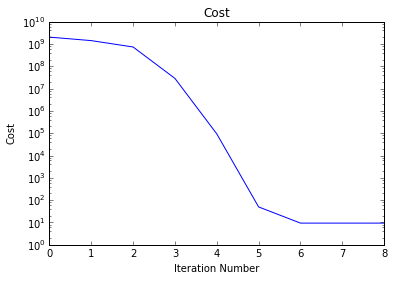

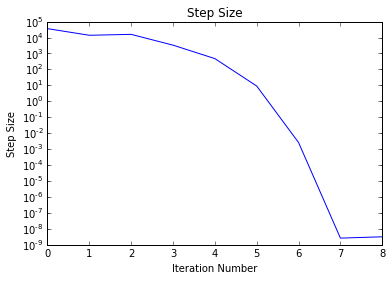

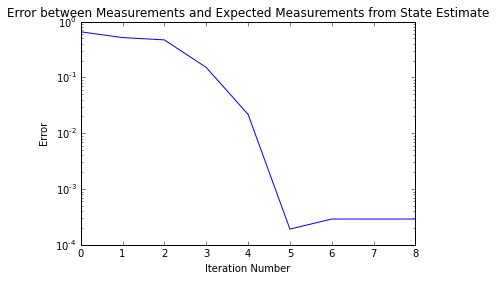

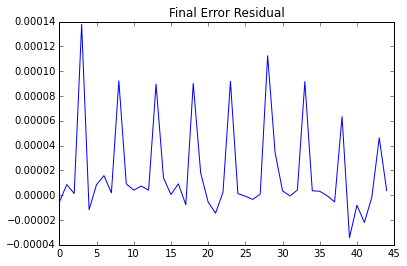

final position estimate: 
[[ 15018.85654294]
 [ 23575.77252585]
 [ -2241.52411178]]


final cost: 9.37673384516


Final Error Covariance: 
[[ 373.57789526  558.32259131  -40.38408262]
 [ 558.32259131  834.62616083  -60.38265314]
 [ -40.38408262  -60.38265314    4.38536355]]


Magnitude of Initial position determination error: 17320.5080757

Magnitude of Final Position Determination Error: 7.62288131654

Y-Position Determination Error: 6.79572493924

Z-Position Determination Error: -0.0191882796967

X-Position Determination Error: 3.45341482103



In [409]:
t = 0.*1800
xg = -1*numpy.array([satPos(t)]).T + numpy.array([[-10000., 10000., 10000.]]).T
measurement = gaussMeasConstruct(t, 0.05)
delta = 0.05
test = gauss(xg, measurement, t, delta, steps=20, lsearch=True, diagnostics=True)

The Gauss-Newton Method rapidly converges to the correct location. Since only angle magnitude and distance magnitude measurements are being used, the iteration may converge to one of two locations (one above the plane formed by the Earth, Sun, and Moon; and one below the plane formed by the Earth, Sun, and Moon). In practice, we will select the location that most nearly agrees with the dynamics model.

In [219]:
# xg = -1*numpy.array([satPosNominal(t)]).T
# file = open("gauss_newton8.txt","w")
# for i in numpy.arange(0,len(satx),1):
#     t = i*1800.
#     xg = -1*numpy.array([satPosNominal(t)]).T
#     delta = 0.05
#     measurement = gaussMeasConstruct(t, delta)
#     estim = gauss(xg, measurement, t, delta, steps=60, lsearch=True, diagnostics=False)
#     err = estim[2]
#     print list(err.flatten())
#     writet = list([t])
#     writest = list(estim[0].flatten())
#     writerr = list(err.flatten())
#     writecov = list(estim[1].flatten())
#     writet.extend(writest)
#     writet.extend(writerr)
#     writet.extend(writecov)
#     for j in writet[0:-1]:
#         file.write(str(j)+' ')
#     file.write(str(writet[-1])+'\n')
# #     xg = estim[0]
# file.close()
print 'Uncomment the above to run. Logged to file for readability of html.'


Uncomment the above to run. Logged to file for readability of html.


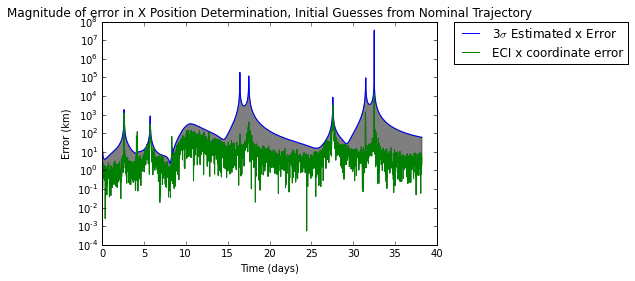

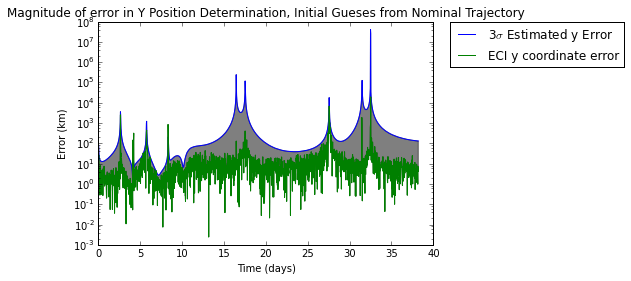

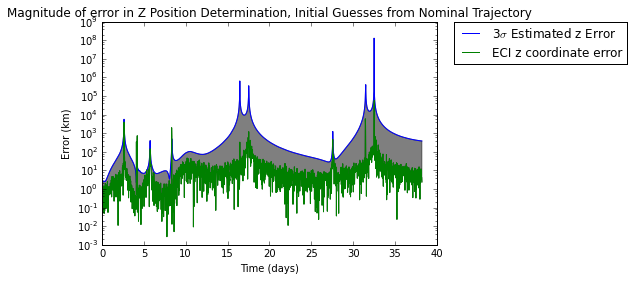

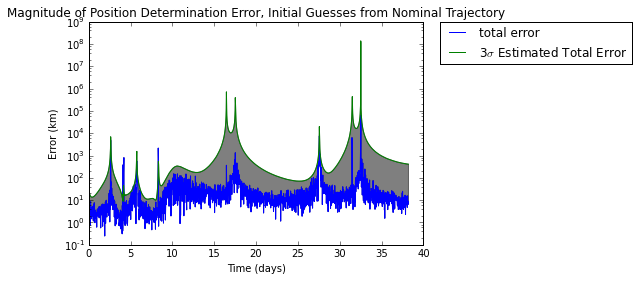

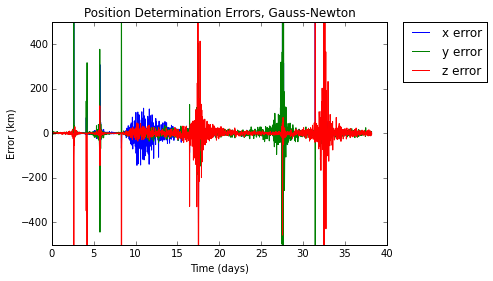

Mean error in x: -0.159879833607
Mean error in y: 14.9389062408
Mean error in z: -22.599035138


In [414]:
def gNewtonResults():
    (time, xguess, yguess, zguess, xerr, yerr, zerr, c11, c12,
     c13, c21, c22, c23, c31, c32, c33) = numpy.loadtxt('gauss_newton7.txt', unpack=True)
    time, xguess, yguess, zguess = time[0:1835], xguess[0:1835], yguess[0:1835], zguess[0:1835]
    xerr, yerr, zerr = xerr[0:1835], yerr[0:1835], zerr[0:1835]
    c11, c12, c13 = c11[0:1835], c12[0:1835], c13[0:1835]
    c21, c22, c23 = c21[0:1835], c22[0:1835], c23[0:1835]
    c31, c32, c33 = c31[0:1835], c32[0:1835], c33[0:1835]
    plt.fill_between(numpy.array(time)/(60*60*24), abs(xerr),
                     3.*numpy.sqrt(c11), color='k',alpha=.5)
    plt.plot(numpy.array(time)/(60*60*24),3.*numpy.sqrt(c11),
             label='3$\sigma$ Estimated x Error'); plt.yscale('log')
    plt.plot(numpy.array(time)/(60*60*24),abs(xerr),
             label='ECI x coordinate error'); plt.yscale('log')
    plt.title('Magnitude of error in X Position Determination, Initial Guesses from Nominal Trajectory')
    plt.ylabel('Error (km)')
    plt.xlabel('Time (days)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    plt.fill_between(numpy.array(time)/(60*60*24), abs(yerr),
                     3.*numpy.sqrt(c22), color='k',alpha=.5)
    plt.plot(numpy.array(time)/(60*60*24),3.*numpy.sqrt(c22),
             label='3$\sigma$ Estimated y Error'); plt.yscale('log')
    plt.plot(numpy.array(time)/(60*60*24),abs(yerr),
             label='ECI y coordinate error'); plt.yscale('log')
    plt.title('Magnitude of error in Y Position Determination, Initial Gueses from Nominal Trajectory')
    plt.ylabel('Error (km)')
    plt.xlabel('Time (days)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    plt.fill_between(numpy.array(time)/(60*60*24), abs(zerr),
                     3.*numpy.sqrt(c33), color='k',alpha=.5)
    plt.plot(numpy.array(time)/(60*60*24),3.*numpy.sqrt(c33),
             label='3$\sigma$ Estimated z Error'); plt.yscale('log')
    plt.plot(numpy.array(time)/(60*60*24),abs(zerr),
             label='ECI z coordinate error'); plt.yscale('log')
    plt.title('Magnitude of error in Z Position Determination, Initial Guesses from Nominal Trajectory')
    plt.ylabel('Error (km)')
    plt.xlabel('Time (days)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    total = numpy.sqrt(numpy.array(abs(xerr))**2. + numpy.array(abs(yerr))**2. + numpy.array(abs(zerr))**2.)
    plt.plot(numpy.array(time/(60*60*24)), total, label='total error')
    plt.plot(numpy.array(time)/(60*60*24),3.*numpy.sqrt(c33+c22+c11),
             label='3$\sigma$ Estimated Total Error')
    plt.fill_between(numpy.array(time)/(60*60*24), abs(total),
                     3.*numpy.sqrt(c33+c22+c11), color='k',alpha=.5)
    plt.yscale('log')
    plt.title('Magnitude of Position Determination Error, Initial Guesses from Nominal Trajectory')
    plt.ylabel('Error (km)')
    plt.xlabel('Time (days)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    plt.plot(numpy.array(time)/(60*60*24), xerr, label='x error')
    plt.plot(numpy.array(time)/(60*60*24), yerr, label='y error')
    plt.plot(numpy.array(time)/(60*60*24), zerr, label='z error')
    plt.ylim([-500, 500])
    plt.title('Position Determination Errors, Gauss-Newton')
    plt.ylabel('Error (km)')
    plt.xlabel('Time (days)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    print 'Mean error in x: '+str(numpy.mean(xerr))
    print 'Mean error in y: '+str(numpy.mean(yerr))
    print 'Mean error in z: '+str(numpy.mean(zerr))
gNewtonResults()

At each timestep in the above plots (separated by 30 minutes), the Gauss-Newton iteration was initialized with a guess based on the nominal spacecraft trajectory, which is up to 8000 km away from the true spacecraft position. Outside of the singular configurations (the spikes), the iteration converges to within a couple hundred kilometers (or much less) of true position. These initial guesses could be provided by a simple dynamics model or, in a lost-in-space situation, derived using unrefined measurements. Each situation will be treated separately.

### Extended Kalman Filter

Total Accumulated Error: 1313.28624433 km


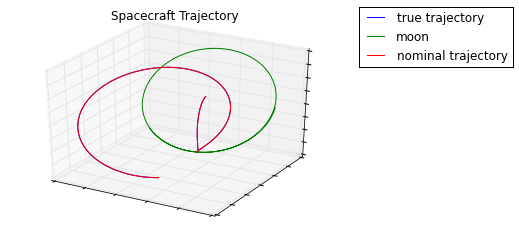

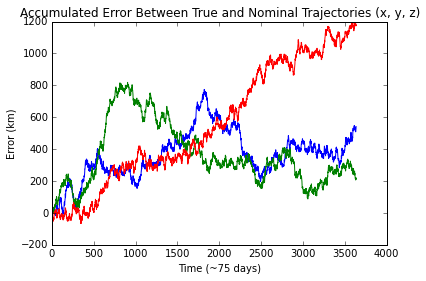

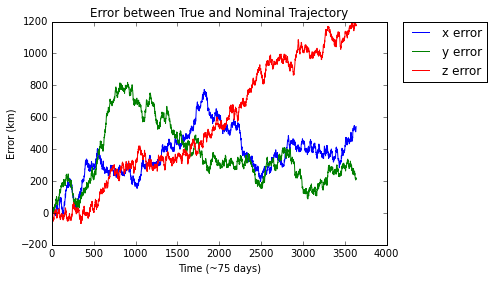

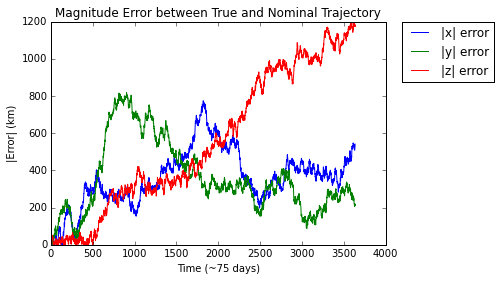

In [372]:
STKTest();

This trajectory has unmodeled deltaV each half hour with standard deviation of ~9m/s. This is a more realistic number.

##### Process Noise Covariance Matrix

I have assumed 0.5m/s/s of unmodeled acceleration between each timestep (30 min). These unmodeled accelerations are due to attitude misalignment, thruster misalignment, thruster mismodeling, etc., and they effect the state variables in the following way. For each position coordinate $x_{i}$:

\begin{align}
q_{i,1} = x_{i} && \dot{q}_{1} = \dot{x} = q_{i,2}\\
q_{i,2} = \dot{x_{i}} && \dot{q}_{2} = \ddot{x} = q_{i,3}\\
q_{i,3} = \ddot{x_{i}} =a && \dot{q}_{i,3} = 0
\end{align}

\begin{align}
\begin{bmatrix}\dot{x_{i}} \\ \ddot{x_{i}} \\ \dddot{x_{i}} \end{bmatrix} = \begin{bmatrix} 0 & 1 & 0 \\ 0 & 0 & 1 \\ 0 & 0 & 0 \end{bmatrix} \begin{bmatrix} x_{i} \\ \dot{x_{i}} \\ \ddot{x_{i}} \end{bmatrix}
\end{align}

Taking the matrix exponential:

\begin{align}
\Phi(t,t_{0}) = \begin{bmatrix}
 1 & \Delta t & \frac{\Delta t^2}{2} \\
 0 & 1 & \Delta t \\
 0 & 0 & 1 \\
\end{bmatrix}
\end{align}

The relationship between acceleration input and the position/velocity state variables are given by the top two components of the third column. These tell us the influence of acceleration on the variables of concern. Rewriting the system model with stochastic acceleration disturbances included, we have:

\begin{align}
{\bf{x}}_{i,k} = \begin{bmatrix}1 & \Delta t\\0 & 1\end{bmatrix}x_{i,k-1} + \begin{bmatrix} a_{i,k}\frac{\Delta t^{2}}{2} \\ a_{i,k}\Delta t \end{bmatrix}
\end{align}

We are now in a position to get the process noise covariance, ${\bf{w_{k}}}$. This is drawn from a zero mean multivariate normal distribution with covariance ${\bf{Q}}_{k}$.

The covariance matrix for a single set of state variables is given by:

\begin{align}
Q &= E\left[ \begin{bmatrix} a_{k}\frac{\Delta t^{2}}{2} \\ a_{k}\Delta t \end{bmatrix} \begin{bmatrix} a_{k}\frac{\Delta t^{2}}{2} & a_{k}\Delta t \end{bmatrix}\right]
\\
&= E\left[\begin{bmatrix}a_{k}^{2}\frac{\Delta t^{4}}{4} & a_{k}^{2}\frac{\Delta t^{3}}{2} \\ a_{k}^{2}\frac{\Delta t^{3}}{2} & a_{k}^{2}\Delta t^{2}\end{bmatrix}\right]\\
&= \begin{bmatrix}\frac{\Delta t^{4}}{4} & \frac{\Delta t^{3}}{2} \\ \frac{\Delta t^{3}}{2} & \Delta t^{2}\end{bmatrix} \sigma_{a}^{2}
\end{align}

So, the full process noise covariance matrix, with independent stochastic acceleration in each direction, is given by:

\begin{align}
Q = \begin{bmatrix}
\frac{\Delta t^{4}}{4}\sigma_{x}^{2} & 0 & 0 & \frac{\Delta t^{3}}{2}\sigma_{x}^{2} & 0 & 0 & 0\\
0 & \frac{\Delta t^{4}}{4}\sigma_{y}^{2} & 0 & 0 &  \frac{\Delta t^{3}}{2}\sigma_{y}^{2} & 0 & 0\\
0 & 0 & \frac{\Delta t^{4}}{4}\sigma_{z}^{2} & 0 & 0 & \frac{\Delta t^{3}}{2}\sigma_{z}^{2} & 0\\
\frac{\Delta t^{3}}{2}\sigma_{x}^{2} & 0 & 0 & \Delta t^{2}\sigma_{x}^{2} & 0 & 0 & 0\\
0 & \frac{\Delta t^{3}}{2}\sigma_{y}^{2} & 0 & 0 & \Delta t^{2}\sigma_{y}^{2} & 0 & 0\\
0 & 0 & \frac{\Delta t^{3}}{2}\sigma_{z}^{2} & 0 & 0 & \Delta t^{2}\sigma_{z}^{2} & 0\\
0 & 0 & 0 & 0 & 0 & 0 & \sigma_{m}^{2}
\end{bmatrix}
\end{align}

In [352]:
def QMat(X, t, sig1=sigmaAcc, deltat=tStep):
    return numpy.array([[(tStep**4.)/4., 0., 0., (tStep**3.)/2., 0., 0., 0.],
                        [0., (tStep**4.)/4., 0., 0., (tStep**3.)/2., 0., 0.],
                        [0., 0., (tStep**4.)/4., 0., 0., (tStep**3.)/2., 0.],
                        [(tStep**3.)/2., 0., 0., tStep**2., 0., 0., 0.],
                        [0., (tStep**3.)/2., 0., 0., tStep**2., 0., 0.],
                        [0., 0., (tStep**3.)/2., 0., 0., tStep**2., 0.],
                        [0., 0., 0., 0., 0., 0., 0.01]])*(sigmaAcc**2.)

We will, however, model the measurement noise. This information is encapsulated in the $R$ matrix.

In [73]:
def R(gnR):
    return gnR

##### Linearization of Nonlinear System Model

In order to implement the filter, the nonlinear system and measurement models must be linearized at each timestep. This requires taking the Jacobian of each set of differential equations with respect to the state variables. Let us begin with the Jacobian of the system model.

\begin{align}
F({\bf{\underline{\hat{x}}}}(t), t) = \frac{\partial{\mathcal{f}}({\bf{\underline{x}}}(t), t)}{\partial{\bf{\underline{x}}}(t)}\bigg{|}_{\bf{\underline{x}}(t)={\bf{\hat{\underline{x}}}}(t)}
\end{align}

$Mathematica$ can be used for a lot of the heavy lifting here. I'll attack this one line of the Jacobian at a time.

\begin{align}
\mathcal{f}_{1} = \dot{x}
\end{align}

\begin{align}
\frac{\partial{\mathcal{f}_{1}}}{\partial{x}} = 0 && \frac{\partial{\mathcal{f}_{1}}}{\partial{y}} = 0 && \frac{\partial{\mathcal{f}_{1}}}{\partial{z}} = 0 &&
\frac{\partial{\mathcal{f}_{1}}}{\partial{\dot{x}}} = 1 && \frac{\partial{\mathcal{f}_{1}}}{\partial{\dot{y}}} = 0 && \frac{\partial{\mathcal{f}_{1}}}{\partial{\dot{z}}} = 0 &&\hspace{6mm} \frac{\partial{\mathcal{f}_{1}}}{\partial{m}}=0
\end{align}

So the first line of the Jacobian is $\begin{bmatrix}0&0&0&1&0&0&0\end{bmatrix}$. Similarly for $\mathcal{f}_{2}$ and $\mathcal{f}_{3}$:

\begin{align}
\mathcal{f}_{2} = \dot{y} && \mathcal{f}_{3} = \dot{y}
\end{align}

\begin{align}
\frac{\partial{\mathcal{f}_{2}}}{\partial{x}} = 0 && \frac{\partial{\mathcal{f}_{2}}}{\partial{y}} = 0 && \frac{\partial{\mathcal{f}_{2}}}{\partial{z}} = 0 &&
\frac{\partial{\mathcal{f}_{2}}}{\partial{\dot{x}}} = 0 && \frac{\partial{\mathcal{f}_{2}}}{\partial{\dot{y}}} = 1 && \frac{\partial{\mathcal{f}_{2}}}{\partial{\dot{z}}} = 0 &&\hspace{6mm} \frac{\partial{\mathcal{f}_{2}}}{\partial{m}}=0
\end{align}

\begin{align}
\frac{\partial{\mathcal{f}_{3}}}{\partial{x}} = 0 && \frac{\partial{\mathcal{f}_{3}}}{\partial{y}} = 0 && \frac{\partial{\mathcal{f}_{3}}}{\partial{z}} = 0 &&
\frac{\partial{\mathcal{f}_{3}}}{\partial{\dot{x}}} = 0 && \frac{\partial{\mathcal{f}_{3}}}{\partial{\dot{y}}} = 0 && \frac{\partial{\mathcal{f}_{3}}}{\partial{\dot{z}}} = 1 &&\hspace{6mm} \frac{\partial{\mathcal{f}_{3}}}{\partial{m}}=0
\end{align}

So the first three lines of the Jacobian are:

\begin{align}
\begin{bmatrix} 0 & 0 & 0 & 1 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 1 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 1 & 0\end{bmatrix}
\end{align}

$\mathcal{f}_{3}$ is given by:

\begin{align}
\ddot{x} = \frac{G M_s \left(x_s-x\right)}{\left(\left(x_s-x\right){}^2+\left(y_s-y\right){}^2+\left(z_s-z\right){}^2\right){}^{3/2}}-\frac{G M_e x}{\left(x^2+y^2+z^2\right)^{3/2}}+\frac{G M_M \left(x_m-x\right)}{\left(\left(x_m-x\right){}^2+\left(y_m-y\right){}^2+\left(z_m-z\right){}^2\right){}^{3/2}}-\frac{GM_{s}x_{s}}{(x_{s}^{2}+y_{s}^{2}+z_{s}^{2})^{3/2}}-\frac{GM_{m}x_{m}}{(x_{m}^{2}+y_{m}^{2}+z_{m}^{2})^{3/2}} + \frac{T_{x}}{m}
\end{align}

And the partial derivatives:

\begin{align}
\frac{\partial{\mathcal{f}}_{3}}{\partial{x}}=
\frac{3 \mu _e \left(x-x_s\right){}^2}{\left(\left(x-x_s\right){}^2+\left(y-y_s\right){}^2+\left(z-z_s\right){}^2\right){}^{5/2}}-\frac{\mu _e}{\left(\left(x-x_s\right){}^2+\left(y-y_s\right){}^2+\left(z-z_s\right){}^2\right){}^{3/2}}+\frac{3 x^2 \mu _e}{\left(x^2+y^2+z^2\right)^{5/2}}-\frac{\mu _e}{\left(x^2+y^2+z^2\right)^{3/2}}+\frac{3 \mu _m \left(x-x_m\right){}^2}{\left(\left(x-x_m\right){}^2+\left(y-y_m\right){}^2+\left(z-z_m\right){}^2\right){}^{5/2}}-\frac{\mu _m}{\left(\left(x-x_m\right){}^2+\left(y-y_m\right){}^2+\left(z-z_m\right){}^2\right){}^{3/2}}
\end{align}

\begin{align}
\frac{\partial{\mathcal{f}}_{3}}{\partial{y}}=
\frac{3 \mu _e \left(x_s-x\right) \left(y_s-y\right)}{\left(\left(x_s-x\right){}^2+\left(y_s-y\right){}^2+\left(z_s-z\right){}^2\right){}^{5/2}}+\frac{3 x y \mu _e}{\left(x^2+y^2+z^2\right)^{5/2}}+\frac{3 \mu _m \left(x_m-x\right) \left(y_m-y\right)}{\left(\left(x_m-x\right){}^2+\left(y_m-y\right){}^2+\left(z_m-z\right){}^2\right){}^{5/2}}
\end{align}

\begin{align}
\frac{\partial{\mathcal{f}}_{3}}{\partial{z}}=
\frac{3 \mu _e \left(x_s-x\right) \left(z_s-z\right)}{\left(\left(x_s-x\right){}^2+\left(y_s-y\right){}^2+\left(z_s-z\right){}^2\right){}^{5/2}}+\frac{3 x z \mu _e}{\left(x^2+y^2+z^2\right)^{5/2}}+\frac{3 \mu _m \left(x_m-x\right) \left(z_m-z\right)}{\left(\left(x_m-x\right){}^2+\left(y_m-y\right){}^2+\left(z_m-z\right){}^2\right){}^{5/2}}
\end{align}

\begin{align}
\frac{\partial{\mathcal{f}_{3}}}{\partial{\dot{x}}} = \frac{\partial{\mathcal{f}_{3}}}{\partial{\dot{y}}} = \frac{\partial{\mathcal{f}_{3}}}{\partial{\dot{z}}} = \frac{\partial{\mathcal{f}_{3}}}{\partial{m}} = 0
\end{align}

$\mathcal{f}_{4}$ is given by:

\begin{align}
\ddot{y} = \frac{G  M_s \left(y_s-y\right)}{\left(\left(x_s-x\right){}^2+\left(y_s-y\right){}^2+\left(z_s-z\right){}^2\right){}^{3/2}}-\frac{G  M_e y}{\left(x^2+y^2+z^2\right)^{3/2}}+\frac{G  M_M \left(y_m-y\right)}{\left(\left(x_m-x\right){}^2+\left(y_m-y\right){}^2+\left(z_m-z\right){}^2\right){}^{3/2}}-\frac{GM_{s}y_{s}}{(x_{s}^{2}+y_{s}^{2}+z_{s}^{2})^{3/2}}-\frac{GM_{m}y_{m}}{(y_{m}^{2}+y_{m}^{2}+z_{m}^{2})^{3/2}}+\frac{T_{y}}{m}
\end{align}

Taking the partial derivatives:

\begin{align}
\frac{\partial{\mathcal{f}}_{4}}{\partial{x}}=
\frac{3 x y \mu _e}{\left(x^2+y^2+z^2\right)^{5/2}}+\frac{3 \mu _m \left(x_s-x\right) \left(y_s-y\right)}{\left(\left(x_s-x\right){}^2+\left(y_s-y\right){}^2+\left(z_s-z\right){}^2\right){}^{5/2}}+\frac{3 \mu _m \left(x_m-x\right) \left(y_m-y\right)}{\left(\left(x_m-x\right){}^2+\left(y_m-y\right){}^2+\left(z_m-z\right){}^2\right){}^{5/2}}
\end{align}

\begin{align}
\frac{\partial{\mathcal{f}}_{4}}{\partial{y}}=
\frac{3 y^2 \mu _e}{\left(x^2+y^2+z^2\right)^{5/2}}-\frac{\mu _e}{\left(x^2+y^2+z^2\right)^{3/2}}+\frac{3 \mu _m \left(y_s-y\right){}^2}{\left(\left(x_s-x\right){}^2+\left(y_s-y\right){}^2+\left(z_s-z\right){}^2\right){}^{5/2}}-\frac{\mu _m}{\left(\left(x_s-x\right){}^2+\left(y_s-y\right){}^2+\left(z_s-z\right){}^2\right){}^{3/2}}+\frac{3 \mu _m \left(y_m-y\right){}^2}{\left(\left(x_m-x\right){}^2+\left(y_m-y\right){}^2+\left(z_m-z\right){}^2\right){}^{5/2}}-\frac{\mu _m}{\left(\left(x_m-x\right){}^2+\left(y_m-y\right){}^2+\left(z_m-z\right){}^2\right){}^{3/2}}
\end{align}

\begin{align}
\frac{\partial{\mathcal{f}}_{4}}{\partial{z}}=
\frac{3 y z \mu _e}{\left(x^2+y^2+z^2\right)^{5/2}}+\frac{3 \mu _m \left(y_s-y\right) \left(z_s-z\right)}{\left(\left(x_s-x\right){}^2+\left(y_s-y\right){}^2+\left(z_s-z\right){}^2\right){}^{5/2}}+\frac{3 \mu _m \left(y_m-y\right) \left(z_m-z\right)}{\left(\left(x_m-x\right){}^2+\left(y_m-y\right){}^2+\left(z_m-z\right){}^2\right){}^{5/2}}
\end{align}

$\mathcal{f}_{5}$ is given by:

\begin{align}
\ddot{z} = \frac{G  M_s \left(z_s-z\right)}{\left(\left(x_s-x\right){}^2+\left(y_s-y\right){}^2+\left(z_s-z\right){}^2\right){}^{3/2}}-\frac{G  M_e z}{\left(x^2+y^2+z^2\right)^{3/2}}+\frac{G  M_M \left(z_m-z\right)}{\left(\left(x_m-x\right){}^2+\left(y_m-y\right){}^2+\left(z_m-z\right){}^2\right){}^{3/2}}-\frac{GM_{s}z_{s}}{(x_{s}^{2}+y_{s}^{2}+z_{s}^{2})^{3/2}}-\frac{GM_{m}z_{m}}{(y_{m}^{2}+y_{m}^{2}+z_{m}^{2})^{3/2}} + \frac{T_{z}}{m}
\end{align}

Taking partial derivatives again:

\begin{align}
\frac{\partial{\mathcal{f}}_{5}}{\partial{x}}=
\frac{3 x z \mu _e}{\left(x^2+y^2+z^2\right)^{5/2}}+\frac{3 \mu _m \left(x_s-x\right) \left(z_s-z\right)}{\left(\left(x_s-x\right){}^2+\left(y_s-y\right){}^2+\left(z_s-z\right){}^2\right){}^{5/2}}+\frac{3 \mu _m \left(x_m-x\right) \left(z_m-z\right)}{\left(\left(x_m-x\right){}^2+\left(y_m-y\right){}^2+\left(z_m-z\right){}^2\right){}^{5/2}}
\end{align}

\begin{align}
\frac{\partial{\mathcal{f}}_{5}}{\partial{y}}=
\frac{3 y z \mu _e}{\left(x^2+y^2+z^2\right)^{5/2}}+\frac{3 \mu _m \left(y_s-y\right) \left(z_s-z\right)}{\left(\left(x_s-x\right){}^2+\left(y_s-y\right){}^2+\left(z_s-z\right){}^2\right){}^{5/2}}+\frac{3 \mu _m \left(y_m-y\right) \left(z_m-z\right)}{\left(\left(x_m-x\right){}^2+\left(y_m-y\right){}^2+\left(z_m-z\right){}^2\right){}^{5/2}}
\end{align}

\begin{align}
\frac{\partial{\mathcal{f}}_{5}}{\partial{z}}=
\frac{3 z^2 \mu _e}{\left(x^2+y^2+z^2\right)^{5/2}}-\frac{\mu _e}{\left(x^2+y^2+z^2\right)^{3/2}}+\frac{3 \mu _m \left(z_s-z\right){}^2}{\left(\left(x_s-x\right){}^2+\left(y_s-y\right){}^2+\left(z_s-z\right){}^2\right){}^{5/2}}-\frac{\mu _m}{\left(\left(x_s-x\right){}^2+\left(y_s-y\right){}^2+\left(z_s-z\right){}^2\right){}^{3/2}}+\frac{3 \mu _m \left(z_m-z\right){}^2}{\left(\left(x_m-x\right){}^2+\left(y_m-y\right){}^2+\left(z_m-z\right){}^2\right){}^{5/2}}-\frac{\mu _m}{\left(\left(x_m-x\right){}^2+\left(y_m-y\right){}^2+\left(z_m-z\right){}^2\right){}^{3/2}}
\end{align}

And finally, $\mathcal{f}_{6}$ is given by:

\begin{align}
\dot{m} = -\frac{||{\bf{T}}||}{I_{sp}g}
\end{align}

For now, I will omit thruster pulses. Since the majority of the mission is spent passively moving under only the influence of gravity, the filter should (I believe) converge even with the periodic pulses (which can be represented as stochastic process noise). The bottom row, therefore, will just be zeros for now. All of this must get bundled up in a function that takes a state and the time as inputs.

In [276]:
def FMat(X, t):
    rec, rem, res = numpy.array([X[0], X[1], X[2]]), moonPos(t), sunPos(t)
    pec, pem, pes = numpy.linalg.norm(rec), numpy.linalg.norm(rem), numpy.linalg.norm(res)
    pcm, pcs = numpy.linalg.norm(rem - rec), numpy.linalg.norm(res - rec)
    rcm, rcs = rem - rec, res - rec
    x, y, z = X[0], X[1], X[2]
    xm, ym, zm = rem[0], rem[1], rem[2]
    xs, ys, zs = res[0], res[1], res[2]
    return numpy.array([[0., 0., 0., 1., 0., 0., 0.],
                        [0., 0., 0., 0., 1., 0., 0.],
                        [0., 0., 0., 0., 0., 1., 0.],
                        [((3.*mu_e*x**2.)/(pec**5.)) - (mu_e/(pec**3.)) - 
                         (mu_m/(((x-xm)**2. + (y-ym)**2. + (z-zm)**2.)**(3./2.))) + 
                         ((3.*mu_m*(x-xm)**2.)/(((x-xm)**2. + (y-ym)**2. + (z-zm)**2.)**(5./2.))) -
                         (mu_s/(((x-xs)**2. + (y-ys)**2. + (z-zs)**2.)**(3./2.))) +
                         ((3.*mu_s*(x-xs)**2.)/(((x-xs)**2. + (y-ys)**2. + (z-zs)**2.)**(5./2.))),
                         ((3.*x*y*mu_e)/(pec**5.)) + 
                         ((3.*mu_m*(xm-x)*(ym-y))/(((x-xm)**2. + (y-ym)**2. + (z-zm)**2.)**(5./2.))) +
                         ((3.*mu_s*(xs-x)*(ys-y))/(((x-xs)**2. + (y-ys)**2. + (z-zs)**2.)**(5./2.))),
                         ((3.*z*x*mu_e)/(pec**5.)) + 
                         ((3.*mu_m*(zm-z)*(xm-x))/(((x-xm)**2. + (y-ym)**2. + (z-zm)**2.)**(5./2.))) +
                         ((3.*mu_s*(zs-z)*(xs-x))/(((x-xs)**2. + (y-ys)**2. + (z-zs)**2.)**(5./2.))),
                         0., 0., 0., 0.],
                        [((3.*y*x*mu_e)/(pec**5.)) + 
                         ((3.*mu_m*(ym-y)*(xm-x))/(((x-xm)**2. + (y-ym)**2. + (z-zm)**2.)**(5./2.))) +
                         ((3.*mu_s*(ys-y)*(xs-x))/(((x-xs)**2. + (y-ys)**2. + (z-zs)**2.)**(5./2.))),
                         ((3.*mu_e*y**2.)/(pec**5.)) - (mu_e/(pec**3.)) - 
                         (mu_m/(((x-xm)**2. + (y-ym)**2. + (z-zm)**2.)**(3./2.))) + 
                         ((3.*mu_m*(y-ym)**2.)/(((x-xm)**2. + (y-ym)**2. + (z-zm)**2.)**(5./2.))) -
                         (mu_s/(((x-xs)**2. + (y-ys)**2. + (z-zs)**2.)**(3./2.))) +
                         ((3.*mu_s*(y-ys)**2.)/(((x-xs)**2. + (y-ys)**2. + (z-zs)**2.)**(5./2.))),
                         ((3.*z*y*mu_e)/(pec**5.)) + 
                         ((3.*mu_m*(zm-z)*(ym-y))/(((x-xm)**2. + (y-ym)**2. + (z-zm)**2.)**(5./2.))) +
                         ((3.*mu_s*(zs-z)*(ys-y))/(((x-xs)**2. + (y-ys)**2. + (z-zs)**2.)**(5./2.))),
                         0., 0., 0., 0.],
                        [((3.*z*x*mu_e)/(pec**5.)) + 
                         ((3.*mu_m*(zm-z)*(xm-x))/(((x-xm)**2. + (y-ym)**2. + (z-zm)**2.)**(5./2.))) +
                         ((3.*mu_s*(zs-zs)*(xs-x))/(((x-xs)**2. + (y-ys)**2. + (z-zs)**2.)**(5./2.))),
                         ((3.*z*y*mu_e)/(pec**5.)) + 
                         ((3.*mu_m*(zm-z)*(ym-y))/(((x-xm)**2. + (y-ym)**2. + (z-zm)**2.)**(5./2.))) +
                         ((3.*mu_s*(zs-z)*(ys-y))/(((x-xs)**2. + (y-ys)**2. + (z-zs)**2.)**(5./2.))),
                         ((3.*mu_e*z**2.)/(pec**5.)) - (mu_e/(pec**3.)) - 
                         (mu_m/(((x-xm)**2. + (y-ym)**2. + (z-zm)**2.)**(3./2.))) + 
                         ((3*mu_m*(z-zm)**2.)/(((x-xm)**2. + (y-ym)**2. + (z-zm)**2.)**(5./2.))) -
                         (mu_s/(((x-xs)**2. + (y-ys)**2. + (z-zs)**2.)**(3./2.))) +
                         ((3.*mu_s*(z-zs)**2.)/(((x-xs)**2. + (y-ys)**2 + (z-zs)**2)**(5./2.))),
                         0., 0., 0., 0.],
                        [0., 0., 0., 0., 0., 0., 0.]])

The output of the above function is the time-dependent Jacobian of the equations of motion.

##### Linearization of Gauss-Newton Measurement Model

Essentiallly the same procedure is now required for the $H$ matrix, which is the Jacobian of the measurement equations at a particular time. Here, we treat the output of the Gauss-Newton iteration (location of Earth relative to spacecraft, in ECI) as the measurement. This leads to an extremely simple measurement model.

\begin{align}
h_{1} = -x && h_{2} = -y && h_{3} = -z
\end{align}

In [306]:
def h(X):
    return numpy.array([-X[0], -X[1], -X[2]]).T

Take the derivative of each $h_{i}$ with respect to each state variable, and compose all partial derivatives in the Jacobian matrix. Start with $h_{1}$:

\begin{align}
\frac{\partial{h_{1}}}{\partial{x}} &= -1 && \frac{\partial{h_{1}}}{\partial{y}} = 0 &&\frac{\partial{h_{1}}}{\partial{z}} =0 && \frac{\partial{h_{1}}}{\partial{\dot{x}}} = 0 && \frac{\partial{h_{1}}}{\partial{\dot{y}}} = 0 &&\frac{\partial{h_{1}}}{\partial{\dot{z}}} =0\\
\frac{\partial{h_{2}}}{\partial{x}} &= 0 && \frac{\partial{h_{2}}}{\partial{y}} = -1 &&\frac{\partial{h_{2}}}{\partial{z}} =0 && \frac{\partial{h_{2}}}{\partial{\dot{x}}} = 0 && \frac{\partial{h_{2}}}{\partial{\dot{y}}} = 0 &&\frac{\partial{h_{2}}}{\partial{\dot{z}}} =0\\
\frac{\partial{h_{3}}}{\partial{x}} &= 0 && \frac{\partial{h_{3}}}{\partial{y}} = 0 &&\frac{\partial{h_{3}}}{\partial{z}} =-1 && \frac{\partial{h_{3}}}{\partial{\dot{x}}} = 0 && \frac{\partial{h_{3}}}{\partial{\dot{y}}} = 0 &&\frac{\partial{h_{3}}}{\partial{\dot{z}}} =0
\end{align}

As before, we bundle this up into a function that takes a state and the time as an argument.

In [76]:
def H():
    return numpy.array([[-1., 0., 0., 0., 0., 0., 0.],
                        [0., -1., 0., 0., 0., 0., 0.],
                        [0., 0., -1., 0., 0., 0., 0.]])

###### Filter Equations

The initial conditions of the spacecraft will be known with high accuracy because they will be nearly identical to those of SLS. Thus, we initialize the filter with a high degree of certainty.

In [280]:
def xinit():
    return [-1.501540312811781e4, -2.356897680091111e4, 
            2.241504923500546e3, -4.865378922082240e-1,
            -5.058763191594085, -8.809883161637991e-1, 5.]

def pinit():
    return numpy.array([[100., 0., 0., 0., 0., 0., 0.],
                        [0., 100., 0., 0., 0., 0., 0.],
                        [0., 0., 100., 0., 0., 0., 0.],
                        [0., 0., 0., 0.0001, 0., 0., 0.],
                        [0., 0., 0., 0., 0.0001, 0., 0.],
                        [0., 0., 0., 0., 0., 0.0001, 0.],
                        [0., 0., 0., 0., 0., 0., 0.01]])

Let us begin with the state estimate propagation, which takes a state (and the time) and generates an estimate for the coming state. This step relies upon the nonlinear system model in the following way:

\begin{align}
{\bf{\dot{\hat{\underline{x}}}}}(t) = {\bf{\underline{\mathcal{f}}}}({\bf{\underline{\hat{x}}}}(t), t, {\bf{\underline{u}}})
\end{align}

These differential equations are numerically integrated to generate an estimate for the coming state. The problem, however, is that the dynamics of the trajectory of interest are extremely difficult to model. The trajectory is influenced by a very large number of thruster pulses, and after swingby the spacecraft becomes very susceptible gravitational influences of the Sun and Jupiter.This makes creating a dynamics model that models the motion with zero-mean error a very challenging task.

However, we can linearlize about a nominal trajectory provided by AGI's STK. STK does the heavy lifting for propagation, and we simply estimate deviations from that nominal trajectory. The state, therefore, will not be the position and velocity of the spacecraft, but instead the deviation in position and velocity of the spacecraft from its nominal position and velocity.

In [346]:
def statePropagation(Xmp, tm, dt):
    a_t = numpy.arange(tm, tm+2*dt, dt)
    asol = integrate.odeint(statePropagate, [Xmp[0], Xmp[1], Xmp[2], Xmp[3], Xmp[4], Xmp[5], 5.], a_t)    
    return asol[-1]

The error covariance matrix is also propagated based on current state and the time. The propagation is muddled by the process noise covariance, $Q$. The $Q$ matrix will be changed for tuning. This differential equation is numerically integrated to generate an estimate of the coming error covariance.

\begin{align}
P_{k+1|k} = F_{k}P_{k|k}F^{T}_{k}+Q_{k}
\end{align}

In [79]:
def errorPropagation(Fk, Pk, Qk):
    return numpy.dot(numpy.dot(Fk, Pk), Fk.T) + Qk

Calculate the innovation:

\begin{align}
\nu(k+1) = z_{k+1}-h(\hat{{\bf{x}}}_{k+1|k})
\end{align}

In [80]:
def nu(z, hvec):
    return z - hvec

Calculate residual covariance:

\begin{align}
S_{k+1} = H_{k+1}\overline{P}_{k+1|k}H^{T}_{k+1} + R_{k+1}
\end{align}

In [81]:
def S(Hkp1, Pkp1k, Rkp1):
    return numpy.dot(numpy.dot(Hkp1, Pkp1k), Hkp1.T) + Rkp1

Calculate the Kalman Gain

\begin{align}
K_{k+1} = P_{k+1|k}H_{k+1}^{T}S_{k+1}^{-1}
\end{align}

In [82]:
def kalmanGain(Pkp1k, Hkp1, Skp1):
    return numpy.dot(numpy.dot(Pkp1k, Hkp1.T), pinv(Skp1))

The Kalman Gain is then used, along with measurements, to correct the original dynamics-based guess for the state.

\begin{align}
{\bf{\underline{\hat{x}}}}_{k+1|k+1}= {\bf{\underline{\hat{x}}}}_{k+1|k} + K_{k}\nu_{k+1}
\end{align}

In [83]:
def stateEstimate(Xkp1k, K, nuk):
    return Xkp1k + numpy.dot(K, nuk)

And the updated covariance estimate:

\begin{align}
P_{k+1|k+1} = \left[\mathcal{I} - K_{k}H_{k}\right]P_{k+1|k}
\end{align}

In [84]:
def covarianceEstimate(K, Hk, Pkp1k):
    return numpy.dot(numpy.eye(7) - numpy.dot(K, Hk), Pkp1k)

###### Filter implementation

In [355]:
def ExtendedKalmanFilter(delta, dt=1800., terminus=1800*(len(satx)-1), raw=False, prognostics=True, write=True):
    times = numpy.arange(0, terminus, dt)
    
    # Initialize the filter
    xk = numpy.array([xinit()]).T
    Pk = pinit()
    
    # Open log file
    if write==True:
        file = open("ekf2.txt","w")
    
    for i in range(len(times)-1800):
        # Propagate State and Covariance
        xkp1k = numpy.array([statePropagation(xk.flatten(), times[i+1], dt)]).T
        if raw==False:
            Fk = FMat(xk, times[i])
        elif raw==True:
            Fk = -1.*FMat(xk, times[i])
        Qk = QMat(xk, times[i])
        Pkp1k = errorPropagation(Fk, Pk, Qk)
        if prognostics==True:
            print 'xk: '+'\n' + str(xk) + '\n'
            print 'Pk: '+'\n' + str(Pk) + '\n'
            print 'Fk: '+'\n' + str(Fk) + '\n'
            print 'Qk: '+'\n' + str(Qk) + '\n'
            print 'Pkp1k: '+'\n' + str(Pkp1k) + '\n'
        if write==True:
            writet = list([times[i+1]])
            writexkp1k = list(xkp1k.flatten())
            writeFk = list(Fk.flatten())
            writeQk = list(Qk.flatten())
            writePkp1k = list(Pkp1k.flatten())
        
        # Take Measurement
        meas = gaussMeasConstruct(times[i+1], delta)
        if raw==False:
            gaussguess = -1*numpy.array([xkp1k.flatten()[0:3]]).T
            gnewt = gauss(gaussguess, meas, times[i+1], delta,
                          steps=25, lsearch=True, diagnostics=False)
            Rkp1 = gnewt[1]
            z = gnewt[0]
        elif raw==True:
            Rkp1 = gaussR(meas, delta)
            z = meas
        else:
            print 'Missed first.'
        if prognostics==True:
            print 'z: '+'\n' + str(z) + '\n'
            print 'R: '+'\n' + str(Rkp1) + '\n'
        if write==True:
            writez = list(z.flatten())
            writeR = list(Rkp1.flatten())
  
        # Calculate Innovation
        if raw==False:
            hvec = h(xkp1k).T
        elif raw==True:
            hvec = gausshConstruct(xkp1k, times[i])
        else:
            print 'Missed second.'
        nuk = z - hvec
        if prognostics==True:
            print 'h: '+'\n' + str(hvec) + '\n'
            print 'nu: '+'\n' + str(nuk) + '\n'
        if write==True:
            writeh = list(hvec.flatten())
            writenu = list(nuk.flatten())
        
        # Calculate Residual Covariance
        if raw==False:
            Hkp1 = H()
        elif raw==True:
            Hkp1 = -1.*HBuildConstruct(xkp1k, times[i])
            add_derivs = numpy.zeros((len(hvec), 4))
            Hkp1 = numpy.hstack((Hkp1, add_derivs))
        else:
            print 'Missed third.'
        Skp1 = S(Hkp1, Pkp1k, Rkp1)
        if prognostics==True:
            print 'Hk: '+'\n' + str(Hkp1) + '\n'
            print 'Sk: '+'\n' + str(Skp1) + '\n'
        if write==True:
            writeHk = list(Hkp1.flatten())
            writeSkp1 = list(Skp1.flatten())
        
        # Calculate Kalman Gain
        K = kalmanGain(Pkp1k, Hkp1, Skp1)
        if prognostics==True:
            print 'Kalman Gain: '+'\n' + str(K) + '\n'
        if write==True:
            writeK = list(K.flatten())
        
        # Update state estimate
        xkp1kp1 = stateEstimate(xkp1k, K, nuk)
        if prognostics==True:
            print 'xkp1kp1: '+'\n' + str(xkp1kp1) + '\n'
        if write==True:
            writexkp1kp1 = list(xkp1kp1.flatten())
        
        # Update covariance estimate
        Pkp1kp1 = covarianceEstimate(K, Hkp1, Pkp1k)
        if prognostics==True:
            print 'Pkp1kp1: '+'\n' + str(Pkp1kp1) + '\n'
        if write==True:
            writePkp1kp1 = list(Pkp1kp1.flatten())
        
        # Find error (for simulation only)
        error = numpy.array([satPos(times[i+1])]).T - numpy.array([[xkp1kp1[0][0]],
                                                                   [xkp1kp1[1][0]],
                                                                   [xkp1kp1[2][0]]])
        print 'Error:' + '\n' + str(error.flatten())+'\n'
        print (Qk[0][0] + Qk[1][1] + Qk[2][2])/(Rkp1[0][0] + Rkp1[1][1] + Rkp1[2][2])
        if write==True:
            writeerror = list(error.flatten())
        
        # Increment time, reset initializations
        xk = xkp1kp1
        Pk = Pkp1kp1
        
        # Write relevant information to file
        if write==True:
            writet.extend(writeerror)
            writet.extend(writePkp1kp1)
            writet.extend(writexkp1kp1)
            writet.extend(writeK)
#             writet.extend(writeSkp1)
#             writet.extend(writeHk)
#             writet.extend(writenu)
#             writet.extend(writeh)
            writet.extend(writeR)
#             writet.extend(writez)
#             writet.extend(writePkp1k)
#             writet.extend(writeQk)
#             writet.extend(writeFk)
#             writet.extend(writexkp1k)
        
        if write==True:
            for j in writet[0:-1]:
                file.write(str(j)+' ')
            file.write(str(writet[-1])+'\n')
        
    file.close()
        
        

Plot results for EKF

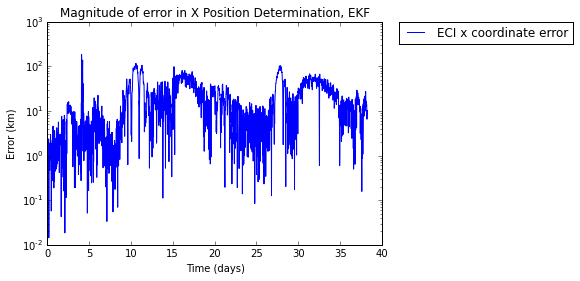

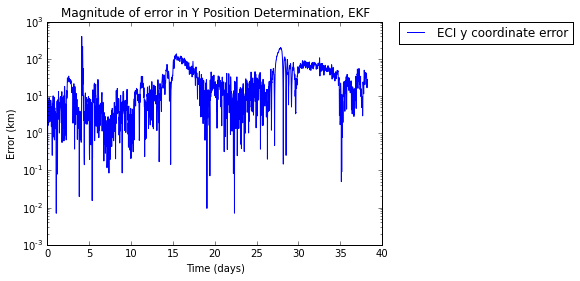

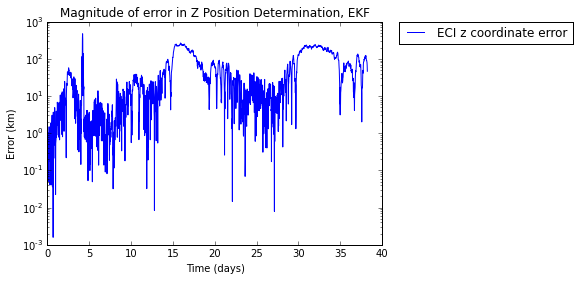

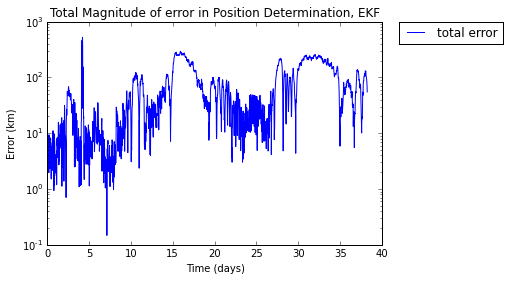

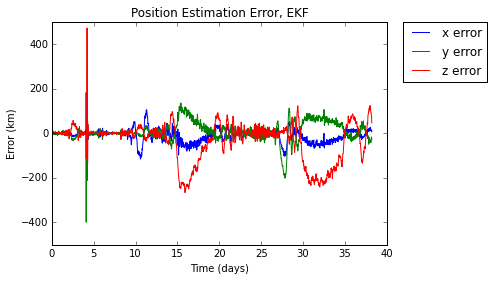

Mean error in x: -11.0195684069
Mean error in y: 9.39989232638
Mean error in z: -34.6546445125


In [420]:
def ekfResults():
    (time, xerr, yerr, zerr, p11, p12, p13, p14, p15, p16, p17,
     p21, p22, p23, p24, p25, p26, p27, p31, p32, p33, p34, p35,
     p36, p37, p41, p42, p43, p44, p45, p46, p47, p51, p52, p53,
     p54, p55, p56, p57, p61, p62, p63, p64, p65, p66, p67,
     p71, p72, p73, p74, p75, p76, p77, xguess, yguess, zguess,
     vxguess, vyguess, vzguess, mguess, k11, k12, k13, k21, k22,
     k23, k31, k32, k33, k41, k42, k43,
     k51, k52, k53, k61, k62, k63, k71, k72, k73, r11, r12,
     r13, r21, r22, r23, r31, r32, r33) = numpy.loadtxt('ekf1.txt', unpack=True)
#     plt.fill_between(numpy.array(time)/(60*60*24), abs(xerr),
#                      3.*numpy.sqrt(p11), color='k',alpha=.5)
#     plt.plot(numpy.array(time)/(60*60*24),3.*numpy.sqrt(p11),
#              label='3$\sigma$ Estimated x Error'); plt.yscale('log')
    plt.plot(numpy.array(time)/(60*60*24),abs(xerr),
             label='ECI x coordinate error'); plt.yscale('log')
    plt.title('Magnitude of error in X Position Determination, EKF')
    plt.ylabel('Error (km)')
    plt.xlabel('Time (days)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
#     plt.fill_between(numpy.array(time)/(60*60*24), abs(yerr),
#                      3.*numpy.sqrt(p22), color='k',alpha=.5)
#     plt.plot(numpy.array(time)/(60*60*24),3.*numpy.sqrt(p22),
#              label='3$\sigma$ Estimated y Error'); plt.yscale('log')
    plt.plot(numpy.array(time)/(60*60*24),abs(yerr),
             label='ECI y coordinate error'); plt.yscale('log')
    plt.title('Magnitude of error in Y Position Determination, EKF')
    plt.ylabel('Error (km)')
    plt.xlabel('Time (days)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
#     plt.fill_between(numpy.array(time)/(60*60*24), abs(zerr),
#                      3.*numpy.sqrt(p33), color='k',alpha=.5)
#     plt.plot(numpy.array(time)/(60*60*24),3.*numpy.sqrt(p33),
#              label='3$\sigma$ Estimated z Error'); plt.yscale('log')
    plt.plot(numpy.array(time)/(60*60*24),abs(zerr),
             label='ECI z coordinate error'); plt.yscale('log')
    plt.title('Magnitude of error in Z Position Determination, EKF')
    plt.ylabel('Error (km)')
    plt.xlabel('Time (days)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    total = numpy.sqrt(numpy.array(abs(xerr))**2. +
                       numpy.array(abs(yerr))**2. +
                       numpy.array(abs(zerr))**2.)
    plt.plot(numpy.array(time/(60*60*24)), total, label='total error')
#     plt.plot(numpy.array(time)/(60*60*24),3.*numpy.sqrt(p33+p22+p11),
#              label='3$\sigma$ Estimated Total Error')
#     plt.fill_between(numpy.array(time)/(60*60*24), abs(total),
#                      3.*numpy.sqrt(p33+p22+p11), color='k',alpha=.5)
    plt.yscale('log')
    plt.title('Total Magnitude of error in Position Determination, EKF')
    plt.ylabel('Error (km)')
    plt.xlabel('Time (days)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    plt.plot(numpy.array(time)/(60*60*24), xerr, label='x error')
    plt.plot(numpy.array(time)/(60*60*24), yerr, label='y error')
    plt.plot(numpy.array(time)/(60*60*24), zerr, label='z error')
    plt.ylim([-500, 500])
    plt.title('Position Estimation Error, EKF')
    plt.ylabel('Error (km)')
    plt.xlabel('Time (days)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    print 'Mean error in x: '+str(numpy.mean(xerr))
    print 'Mean error in y: '+str(numpy.mean(yerr))
    print 'Mean error in z: '+str(numpy.mean(zerr))
ekfResults()

## Comparison of Performance

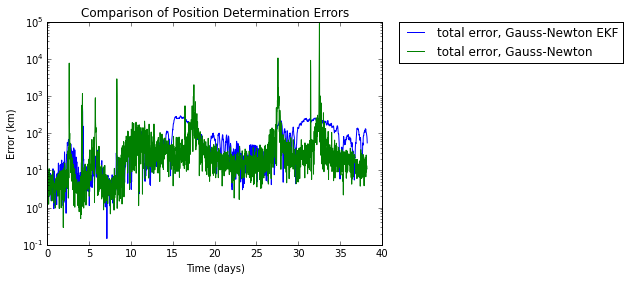

In [415]:
def moneyShot():
    (time, xerr, yerr, zerr, p11, p12, p13, p14, p15, p16, p17,
     p21, p22, p23, p24, p25, p26, p27, p31, p32, p33, p34, p35,
     p36, p37, p41, p42, p43, p44, p45, p46, p47, p51, p52, p53,
     p54, p55, p56, p57, p61, p62, p63, p64, p65, p66, p67,
     p71, p72, p73, p74, p75, p76, p77, xguess, yguess, zguess,
     vxguess, vyguess, vzguess, mguess, k11, k12, k13, k21, k22,
     k23, k31, k32, k33, k41, k42, k43,
     k51, k52, k53, k61, k62, k63, k71, k72, k73, r11, r12,
     r13, r21, r22, r23, r31, r32, r33) = numpy.loadtxt('ekf1.txt', unpack=True)
    
    (timeg, xguessg, yguessg, zguessg, xerrg, yerrg, zerrg, c11, c12,
     c13, c21, c22, c23, c31, c32, c33) = numpy.loadtxt('gauss_newton7.txt', unpack=True)
    timeg, xguessg, yguessg, zguessg = timeg[0:1835], xguessg[0:1835], yguessg[0:1835], zguessg[0:1835]
    xerrg, yerrg, zerrg = xerrg[0:1835], yerrg[0:1835], zerrg[0:1835]
    c11, c12, c13 = c11[0:1835], c12[0:1835], c13[0:1835]
    c21, c22, c23 = c21[0:1835], c22[0:1835], c23[0:1835]
    c31, c32, c33 = c31[0:1835], c32[0:1835], c33[0:1835]
    
    total = numpy.sqrt(numpy.array(abs(xerr))**2. + numpy.array(abs(yerr))**2. + numpy.array(abs(zerr))**2.)
    plt.plot(numpy.array(time/(60*60*24)), total, label='total error, Gauss-Newton EKF')
#     plt.plot(numpy.array(time)/(60*60*24),3.*numpy.sqrt(p33+p22+p11),
#              label='3$\sigma$ Estimated Total Error')
#     plt.fill_between(numpy.array(time)/(60*60*24), abs(total),
#                      3.*numpy.sqrt(p33+p22+p11), color='k',alpha=.5)
    totalg = numpy.array(numpy.array(abs(xerrg)) + numpy.array(abs(yerrg)) + numpy.array(abs(zerrg)))
    plt.plot(numpy.array(timeg/(60*60*24)), totalg, label='total error, Gauss-Newton')
#     plt.plot(numpy.array(time)/(60*60*24),3.*numpy.sqrt(c33+c22+c11),
#              label='3$\sigma$ Estimated Total Error')
#     plt.fill_between(numpy.array(time)/(60*60*24), abs(totalg),
#                      3.*numpy.sqrt(c33+c22+c11), color='k',alpha=.5)
    plt.yscale('log')
    plt.title('Comparison of Position Determination Errors')
    plt.ylabel('Error (km)')
    plt.xlabel('Time (days)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
moneyShot()

In non-singular configurations, the performance of the EKF and the Gauss-Newton iteration are nearly identical. In singular configurations, the dynamics model in the EKF propagates the spacecraft, smoothing over the spikes present in the Gauss-Newton estimates.